In [33]:
import os
import logging
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

# Load environment variables from .env file
load_dotenv()


True

In [34]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---- Snowflake connection setup ----
def get_snowflake_engine():
    """
    Create a SQLAlchemy engine for Snowflake using a Programmatic Access Token (PAT).
    Reads credentials from environment variables (.env file).
    Does not specify database/schema to allow access to multiple databases and schemas.
    """
    # Read credentials from environment variables
    account = os.getenv('SNOWFLAKE_ACCOUNT')
    user = os.getenv('SNOWFLAKE_USER')
    warehouse = os.getenv('SNOWFLAKE_WAREHOUSE')
    role = os.getenv('SNOWFLAKE_ROLE')
    pat = os.getenv('SNOWFLAKE_PAT')

    # Validate required environment variables
    if not all([account, user, warehouse, role, pat]):
        missing_vars = [var for var, val in [
            ('SNOWFLAKE_ACCOUNT', account),
            ('SNOWFLAKE_USER', user),
            ('SNOWFLAKE_WAREHOUSE', warehouse),
            ('SNOWFLAKE_ROLE', role),
            ('SNOWFLAKE_PAT', pat)
        ] if not val]
        raise ValueError(f"Missing required environment variables: {', '.join(missing_vars)}")

    logger.info("Using Snowflake Programmatic Access Token authentication")
    logger.info(f"Connecting as user: {user} to account: {account}")

    url = URL(
        account='CREDITGENIE-DATA',
        user='YGU',
        password='CENSORED_WITH_CHANGE', 
        warehouse='COMPUTE_WH',
        role='DSCI',
        # Note: database and schema are intentionally omitted to allow 
        # access to multiple databases/schemas via fully qualified table names
    )

    return create_engine(url, connect_args={"client_session_keep_alive": True})


In [35]:
def execute_query(sql: str, return_dataframe: bool = True):
    """
    Execute a SQL query against Snowflake with integrated connection management.
    This version doesn't clean the SQL - assumes it's already properly formatted.
    
    Args:
        sql (str): The SQL query to execute (should be clean, no markdown)
        return_dataframe (bool): If True, returns pandas DataFrame. If False, returns raw result.
    
    Returns:
        pandas.DataFrame or result: Query results
        
    Raises:
        Exception: If query execution fails
    """
    engine = get_snowflake_engine()
    
    try:
        with engine.connect() as conn:
            if return_dataframe:
                df = pd.read_sql(sql.strip(), conn)
                logger.info(f"Query succeeded, returned {len(df)} rows.")
                return df
            else:
                result = conn.execute(sql.strip())
                logger.info("Query executed successfully.")
                return result
                
    except Exception as e:
        logger.error(f"SQL execution failed: {e}")
        logger.error(f"Failed query: {sql.strip()}")
        raise


In [36]:
# Test the connection and load the data
df = execute_query("SELECT * FROM TEAM.DSCI.SUBSEQUENTADVANCEQUALITYPROMAX LIMIT 10")
df

INFO:__main__:Using Snowflake Programmatic Access Token authentication
INFO:__main__:Connecting as user: YGU to account: CREDITGENIE-DATA
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.17.4, Python Version: 3.9.6, Platform: macOS-15.6.1-arm64-arm-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:__main__:Query succeeded, returned 10 rows.


,createdat,accountageinmonths,averagedaysbetweenincometransactions,averageincome,currentbalance,xdayaveragebalance,washighlydelinquentwithlastrepayment,wasseverelydelinquentwithlastrepayment,customerid,user_id_x,...,plaid_transaction_batch_feature_view__transaction_amount_positive_max_14d,plaid_transaction_batch_feature_view__transaction_amount_negative_max_14d,plaid_transaction_batch_feature_view__transaction_amount_positive_min_14d,plaid_transaction_batch_feature_view__transaction_amount_negative_min_14d,plaid_transaction_batch_feature_view__net_transaction_amount_14d,plaid_transaction_batch_feature_view__transaction_removed_count_14d,user_id_y,cash_advance_batch_feature_view__repayment_count_180d,cash_advance_batch_feature_view__status_repaid_count_180d,day28delinq
0,2025-09-12T16:25:01.879Z,17.15,4,5899.48,-72.56,-96.97,False,False,18d346c6-1b1f-4359-a435-81ebe3f6c554,3491dfbd-d73c-4cb4-ac3f-f24b3989b384,...,1256.34,-3.00,1.00,-1305.00,4744.47,0.0,18d346c6-1b1f-4359-a435-81ebe3f6c554,NaN,NaN,0
1,2025-08-03T23:39:30.736Z,8.96,4,4548.38,1.42,157.84,False,False,5a3c45c8-46dd-40e8-8037-80ff8d6926e4,4695cf78-b97c-46ed-85d1-260990bd92fe,...,443.00,-0.01,0.01,-723.41,1364.86,0.0,5a3c45c8-46dd-40e8-8037-80ff8d6926e4,3.0,1.0,0
2,2025-07-03T19:34:44.361Z,13.35,7,2345.23,-28.32,-31.90,True,False,17528d1e-52d2-4575-8766-911b0480f0eb,ddd74c3e-c3c7-4b79-9d28-4b2105674f8e,...,500.00,-36.92,1.00,-1138.83,141.07,0.0,17528d1e-52d2-4575-8766-911b0480f0eb,NaN,NaN,0
3,2025-07-08T11:38:37.924Z,49.34,4,3158.69,665.78,1142.39,False,False,4da61472-27e4-4974-bd0b-b8ae8872b7e6,38eaeec7-8025-4023-8112-338dce0abfa5,...,495.00,-30.00,1.99,-1209.45,672.88,0.0,4da61472-27e4-4974-bd0b-b8ae8872b7e6,NaN,NaN,0
4,2025-07-03T20:15:45.840Z,11.96,4,1093.34,144.81,92.06,False,False,6c310bf1-633a-4be3-a97c-eb088f8d1458,7930ad80-91a8-45fe-ab9b-7ceb49a9bbba,...,200.00,-66.01,2.87,-205.48,162.52,0.0,6c310bf1-633a-4be3-a97c-eb088f8d1458,NaN,NaN,1
5,2025-08-29T16:04:57.250Z,19.24,7,3451.18,424.84,202.05,False,False,f81b50f0-839d-48fc-a50e-5fa100088ea9,595a6d0d-1690-4c25-9634-11e09ac6de38,...,522.50,-1.50,1.50,-844.96,54.07,0.0,f81b50f0-839d-48fc-a50e-5fa100088ea9,5.0,5.0,0
6,2025-07-03T23:44:00.282Z,34.53,7,3786.67,1243.76,839.47,False,False,2c0c27b4-a836-488a-99bf-204ad8767d55,c81b770d-53aa-4f5d-a487-ac913517a2f6,...,631.81,-4.98,3.89,-1093.36,1026.25,0.0,2c0c27b4-a836-488a-99bf-204ad8767d55,NaN,NaN,0
7,2025-07-03T13:08:36.916Z,7.38,14,1416.28,86.75,185.62,False,False,0878e09e-ec3d-4b53-8b57-ff3ccf73f630,bce74d95-b066-4d97-909c-112a4bb53e71,...,53.10,-0.77,0.01,-5.77,253.00,0.0,0878e09e-ec3d-4b53-8b57-ff3ccf73f630,NaN,NaN,0
8,2025-08-21T14:39:40.155Z,14.11,14,2445.26,6.53,278.21,False,False,9992bac4-27b6-4405-9ad3-7e7762b6d4f9,ec880879-d7a6-404c-be39-f8232a59b87a,...,548.96,-1479.13,4.00,-1479.13,1540.61,0.0,9992bac4-27b6-4405-9ad3-7e7762b6d4f9,2.0,2.0,1
9,2025-07-03T05:35:43.009Z,17.00,4,21384.57,4.48,422.34,False,False,b98d5bc6-a8fe-4ac7-b110-843256bf367c,115c702a-4f34-441f-909a-e5958612a027,...,673.50,-0.03,0.51,-1132.23,1621.55,0.0,b98d5bc6-a8fe-4ac7-b110-843256bf367c,NaN,NaN,1


In [37]:
# Load the full dataset for analysis
df_full = execute_query("SELECT * FROM TEAM.DSCI.SUBSEQUENTADVANCEQUALITYPROMAX")
print(f"Loaded {len(df_full)} rows from TEAM.DSCI.SUBSEQUENTADVANCEQUALITYPROMAX")
df_full.head()


INFO:__main__:Using Snowflake Programmatic Access Token authentication
INFO:__main__:Connecting as user: YGU to account: CREDITGENIE-DATA
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 3.17.4, Python Version: 3.9.6, Platform: macOS-15.6.1-arm64-arm-64bit
INFO:snowflake.connector.connection:Connecting to GLOBAL Snowflake domain
INFO:__main__:Query succeeded, returned 432520 rows.


Loaded 432520 rows from TEAM.DSCI.SUBSEQUENTADVANCEQUALITYPROMAX


,createdat,accountageinmonths,averagedaysbetweenincometransactions,averageincome,currentbalance,xdayaveragebalance,washighlydelinquentwithlastrepayment,wasseverelydelinquentwithlastrepayment,customerid,user_id_x,...,plaid_transaction_batch_feature_view__transaction_amount_positive_max_14d,plaid_transaction_batch_feature_view__transaction_amount_negative_max_14d,plaid_transaction_batch_feature_view__transaction_amount_positive_min_14d,plaid_transaction_batch_feature_view__transaction_amount_negative_min_14d,plaid_transaction_batch_feature_view__net_transaction_amount_14d,plaid_transaction_batch_feature_view__transaction_removed_count_14d,user_id_y,cash_advance_batch_feature_view__repayment_count_180d,cash_advance_batch_feature_view__status_repaid_count_180d,day28delinq
0,2025-07-15T17:56:05.127Z,15.55,7,1126.98,0.08,72.04,False,False,ec6c548b-561d-4cd7-b143-07b8f0a226f2,2d9b4eae-efbb-4f5c-8ab4-e355f1312345,...,532.0,-1.75,5.00,-531.62,149.40,0.0,ec6c548b-561d-4cd7-b143-07b8f0a226f2,1.0,1.0,0
1,2025-09-07T13:32:17.460Z,21.30,5,NaN,292.16,185.01,False,False,2abdcc0e-2267-4d87-8a0e-32283676b29b,f8aeb8c5-8bb7-4897-b52e-0c9ada1739d4,...,650.0,-1.30,1.50,-2267.45,891.68,0.0,2abdcc0e-2267-4d87-8a0e-32283676b29b,4.0,4.0,0
2,2025-07-11T15:49:45.250Z,13.58,14,7687.38,1280.77,1582.95,False,False,60ad5689-c033-4c4f-9d60-c60d7a158deb,c14485ea-4dc6-45c1-8146-2a8aaff63cff,...,1200.0,-2.00,0.26,-2400.00,-2626.54,0.0,60ad5689-c033-4c4f-9d60-c60d7a158deb,0.0,0.0,0
3,2025-08-03T02:05:41.194Z,6.87,5,NaN,36.58,95.97,False,False,a0d132c7-934d-462a-b434-d87ba1758cc0,a69a0fd3-1bb7-4999-a4b7-ccc7c5c5859d,...,1000.0,-10.00,2.65,-1064.20,799.15,0.0,a0d132c7-934d-462a-b434-d87ba1758cc0,NaN,NaN,0
4,2025-07-03T11:08:20.277Z,16.04,7,1106.35,621.11,761.29,False,False,11acdb9b-b4d0-4e2c-8734-2f6ea31ba772,887e42f0-872a-4ae1-8762-2758f56c523b,...,900.0,-1.39,200.00,-900.00,-23.62,0.0,11acdb9b-b4d0-4e2c-8734-2f6ea31ba772,NaN,NaN,1


In [38]:
# # -----------------------------
# # Streamlit app: 28D Tree Model (OTV split + calibration option)
# # -----------------------------
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import roc_auc_score, average_precision_score

# def make_week(df, date_col="CREATEDAT", weekfreq="W-MON"):
#     s = pd.to_datetime(df[date_col], errors="coerce")
#     return s.dt.to_period(weekfreq).dt.to_timestamp()

# def prior_shift_adjust(p, pi_train, pi_app):
#     """Bayes prior correction when the application base rate differs from train."""
#     a = (pi_app / pi_train)
#     b = ((1 - pi_app) / (1 - pi_train))
#     num = p * a
#     den = num + (1 - p) * b
#     return np.clip(num / den, 1e-6, 1 - 1e-6)

# with st.sidebar:
#     st.header("Model Settings")
#     max_depth = st.slider("Tree max_depth", 2, 8, 4, 1)
#     min_leaf = st.number_input("min_samples_leaf", min_value=50, max_value=5000, value=200, step=50)
#     otv_weeks = st.slider("OTV window (weeks)", 2, 12, 4, 1)
#     balanced = st.checkbox("class_weight = 'balanced'", value=True)
#     calibrate = st.checkbox("Calibrate probs (isotonic)", value=True)
#     prior_adjust = st.checkbox("Prior-adjust to OTV base rate", value=False)

# # 1) Load data (Snowpark -> pandas)
# sp_df = session.table("TEAM.DBI.SUBSEQUENTADVANCEQUALITY")

# num_features = [
#     "ACCOUNTAGEINMONTHS",
#     "AVERAGEDAYSBETWEENINCOMETRANSACTIONS",
#     "AVERAGEINCOME",
#     "CURRENTBALANCE",
#     "XDAYAVERAGEBALANCE",
# ]
# flag_features = [
#     "WASHIGHLYDELINQUENTWITHLASTREPAYMENT",
#     "WASSEVERELYDELINQUENTWITHLASTREPAYMENT",
# ]
# feature_cols = num_features + flag_features

# sp_clean = (
#     sp_df.select(
#         "ADVANCEID",
#         "CREATEDAT",
#         *[col(c).cast(DoubleType()).alias(c) for c in num_features],
#         *[col(c).cast(IntegerType()).alias(c) for c in flag_features],
#         col("DAY28DELINQ").cast(IntegerType()).alias("BAD_28D"),
#     )
#     .filter(col("BAD_28D").is_not_null())
# )

# pdf = sp_clean.to_pandas()

# if pdf.empty:
#     st.warning("No rows found with non-null BAD_28D (DAY28DELINQ) in the view.")
#     st.stop()

# # 2) Build WEEK and do OTV split: last `otv_weeks` weeks as test
# pdf["WEEK"] = make_week(pdf, "CREATEDAT", "W-MON")
# max_week = pdf["WEEK"].max()
# cutoff_week = max_week - pd.offsets.Week(otv_weeks)

# train_mask = pdf["WEEK"] <= cutoff_week
# test_mask  = pdf["WEEK"] >  cutoff_week

# if not (train_mask.any() and test_mask.any()):
#     st.error("OTV split produced empty train or test. Reduce the 'OTV window (weeks)'.")
#     st.stop()

# # 3) Train/test sets (OTV)
# X = pdf[feature_cols]
# y = pdf["BAD_28D"].astype(int)

# X_train, y_train = X[train_mask], y[train_mask]
# X_test,  y_test  = X[test_mask],  y[test_mask]

# # 4) Train model
# clf = DecisionTreeClassifier(
#     max_depth=max_depth,
#     min_samples_leaf=int(min_leaf),
#     class_weight=("balanced" if balanced else None),
#     random_state=42,
# )
# clf.fit(X_train, y_train)

# # Optionally calibrate on the TRAIN window (isotonic by default)
# prober = clf
# if calibrate:
#     prober = CalibratedClassifierCV(clf, method="isotonic", cv=5)
#     prober.fit(X_train, y_train)

# # 5) Metrics (OTV)
# y_prob_test = prober.predict_proba(X_test)[:, 1]

# # Optional prior/base-rate adjustment to OTV test rate
# if prior_adjust:
#     y_prob_test = prior_shift_adjust(
#         y_prob_test,
#         pi_train=y_train.mean(),
#         pi_app=y_test.mean()
#     )

# train_acc = clf.score(X_train, y_train)  # accuracy of raw classifier on train
# test_acc = clf.score(X_test, y_test)     # accuracy on test (threshold=0.5)
# roc = roc_auc_score(y_test, y_prob_test) if len(np.unique(y_test)) > 1 else float("nan")
# pr  = average_precision_score(y_test, y_prob_test) if len(np.unique(y_test)) > 1 else float("nan")

# c1, c2, c3 = st.columns(3)
# c1.metric("Rows", f"{len(pdf):,}")
# c2.metric("Observed Bad Rate (overall)", f"{y.mean():.2%}")
# c3.metric("Features", f"{len(feature_cols)}")

# calib_tag = " + calibrated" if calibrate else ""
# prior_tag = " + prior-adjusted" if prior_adjust else ""
# st.subheader(
#     f"Performance (OTV split — test = last {otv_weeks} weeks; cutoff {cutoff_week.date()}){calib_tag}{prior_tag}"
# )
# m1, m2, m3, m4 = st.columns(4)
# m1.metric("Train Accuracy", f"{train_acc:.3f}")
# m2.metric("Test Accuracy", f"{test_acc:.3f}")
# m3.metric("ROC-AUC", f"{roc:.3f}" if not np.isnan(roc) else "N/A")
# m4.metric("PR-AUC", f"{pr:.3f}" if not np.isnan(pr) else "N/A")

# # 6) Rules & importance
# with st.expander("Tree rules (human-readable)"):
#     st.text(export_text(clf, feature_names=list(X.columns)))

# with st.expander("Feature importance"):
#     fi = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
#     st.dataframe(fi.rename("importance"))

# # 7) Worst-population leaves (segments) scored on the FULL dataset
# #    (Use the calibrated/prior-adjusted probabilities for scoring as well.)
# pdf["LEAF_ID"] = clf.apply(X)
# p_full = prober.predict_proba(X)[:, 1]
# if prior_adjust:
#     # align to the OTV test base rate for consistency in your gains chart/leaf view
#     p_full = prior_shift_adjust(p_full, pi_train=y_train.mean(), pi_app=y_test.mean())

# pdf["P_BAD"] = p_full

# leaf_summary = (
#     pdf.groupby("LEAF_ID")
#       .agg(
#           rows=("ADVANCEID", "count"),
#           bad_rate=("BAD_28D", "mean"),
#           p_bad_avg=("P_BAD", "mean"),
#           avg_income=("AVERAGEINCOME", "mean"),
#           avg_balance=("CURRENTBALANCE", "mean"),
#           avg_xday_bal=("XDAYAVERAGEBALANCE", "mean"),
#           share_hdelinq=("WASHIGHLYDELINQUENTWITHLASTREPAYMENT", "mean"),
#           share_sdelinq=("WASSEVERELYDELINQUENTWITHLASTREPAYMENT", "mean"),
#       )
#       .sort_values(["bad_rate", "p_bad_avg", "rows"], ascending=[False, False, False])
#       .reset_index()
# )

# st.subheader("Worst Leaves (Segments)")
# st.caption("Sorted by observed bad_rate, then average predicted probability, then size.")
# st.dataframe(leaf_summary.head(20))


Model Settings:
- max_depth: 6
- min_leaf: 200
- otv_weeks: 4
- balanced: False
- calibrate: True
- prior_adjust_global: False
- prior_adjust_by_bucket_flag: True
✓ Auto-detected 105 numeric features
✓ Auto-detected 2 flag/categorical features
✓ Total: 107 features

Available columns in the dataset:
['createdat', 'accountageinmonths', 'averagedaysbetweenincometransactions', 'averageincome', 'currentbalance', 'xdayaveragebalance', 'washighlydelinquentwithlastrepayment', 'wasseverelydelinquentwithlastrepayment', 'customerid', 'user_id_x', 'advanceid', 'timestamp', 'advanceamount', 'advancenumber', 'days_until_repayment', 'repayment_status_at_30d', 'competitor_cash_advance_taken_batch_feature_view__cnt_all_advance_taken_120d', 'competitor_cash_advance_taken_batch_feature_view__cnt_dave_taken_120d', 'competitor_cash_advance_taken_batch_feature_view__cnt_earnin_taken_120d', 'competitor_cash_advance_taken_batch_feature_view__cnt_klover_taken_120d', 'competitor_cash_advance_taken_batch_featur

/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1150314486.py:154: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pdf["BAD_28D"] = pd.to_numeric(pdf["day28delinq"], errors='coerce').astype('Int64')


Dataset loaded: 432520 rows with valid BAD_28D
Train samples: 326041, Test samples: 106479
Cutoff week: 2025-08-26 00:00:00
✓ Monotonic constraints: 4 negative, 3 positive, 100 unconstrained


/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1150314486.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period(weekfreq).dt.to_timestamp()
/Users/yifangu/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


MODEL PERFORMANCE METRICS
Rows: 432,520
Observed Bad Rate (overall): 12.09%
ROC-AUC (OTV): 0.747
Brier (OTV): 0.0917

Performance (OTV test = last 4 weeks; cutoff 2025-08-26) — calibrated, per-week prior-adjust


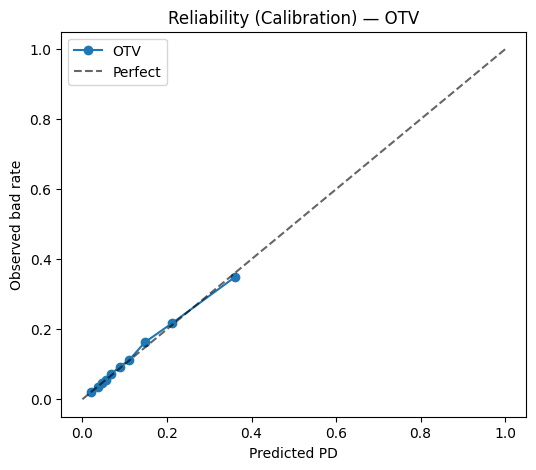


FEATURE IMPORTANCE
accountageinmonths                                                                      0.0
competitor_cash_advance_repayment_batch_feature_view__cnt_floatme_full_repayment_10d    0.0
competitor_cash_advance_repayment_batch_feature_view__cnt_chime_repay_10d               0.0
competitor_cash_advance_repayment_batch_feature_view__cnt_brigit_repay_10d              0.0
competitor_cash_advance_repayment_batch_feature_view__cnt_empower_repay_10d             0.0
                                                                                       ... 
competitor_cash_advance_taken_batch_feature_view__cnt_empower_taken_10d                 0.0
competitor_cash_advance_taken_batch_feature_view__cnt_albert_taken_10d                  0.0
competitor_cash_advance_taken_batch_feature_view__cnt_cleo_taken_10d                    0.0
competitor_cash_advance_taken_batch_feature_view__cnt_floatme_taken_10d                 0.0
wasseverelydelinquentwithlastrepayment                      

In [61]:
# -----------------------------
# 28D Tree Model (OTV split + time-aware calibration + monotonic constraints)
# -----------------------------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.ensemble import HistGradientBoostingClassifier  # supports monotonic_cst

def make_week(df, date_col="createdat", weekfreq="W-MON"):
    s = pd.to_datetime(df[date_col], errors="coerce")
    return s.dt.to_period(weekfreq).dt.to_timestamp()

def prior_shift_adjust(p, pi_train, pi_app):
    """Scalar Bayes prior correction (global)."""
    a = (pi_app / pi_train)
    b = ((1 - pi_app) / (1 - pi_train))
    num = p * a
    den = num + (1 - p) * b
    return np.clip(num / den, 1e-6, 1 - 1e-6)

def prior_shift_by_bucket(probs, bucket_series, pi_train, pi_app_by_bucket):
    """
    Vectorized per-bucket prior shift.
    probs: 1D array-like of probabilities aligned to bucket_series index
    bucket_series: pandas Series of bucket keys (e.g., WEEK), aligned to probs
    pi_train: global train base rate (float)
    pi_app_by_bucket: Series mapping bucket -> observed base rate
    """
    p = pd.Series(np.clip(np.asarray(probs, float), 1e-6, 1-1e-6), index=bucket_series.index)
    pis = bucket_series.map(pi_app_by_bucket).fillna(pi_train).astype(float)
    a = (pis / pi_train)
    b = ((1 - pis) / (1 - pi_train))
    num = p * a
    den = num + (1 - p) * b
    return np.clip(num / den, 1e-6, 1 - 1e-6)

# Model Settings (converted from Streamlit to static values)
max_depth = 6
min_leaf = 200
otv_weeks = 4
balanced = False
calibrate = True
prior_adjust_global = False
prior_adjust_by_bucket_flag = True

print("Model Settings:")
print(f"- max_depth: {max_depth}")
print(f"- min_leaf: {min_leaf}")
print(f"- otv_weeks: {otv_weeks}")
print(f"- balanced: {balanced}")
print(f"- calibrate: {calibrate}")
print(f"- prior_adjust_global: {prior_adjust_global}")
print(f"- prior_adjust_by_bucket_flag: {prior_adjust_by_bucket_flag}")


# ===== AUTO-DETECT ALL FEATURES (EFFICIENT FOR 100+ FEATURES) =====
# Just define what you DON'T want (IDs, timestamps, targets, metadata)
exclude_cols = [
    'createdat', 
    'advanceid', 
    'customerid',
    'user_id_x',
    'user_id_y',
    'timestamp',
    'advanceamount',
    'advancenumber',
    'days_until_repayment',
    'repayment_status_at_30day',
    'day28delinq', 
    'nth_advance',
    'repayment_status_at_30d'
]

# Auto-detect all feature columns
all_feature_cols = [col for col in df_full.columns if col.lower() not in [c.lower() for c in exclude_cols]]

# Automatically categorize by data type
num_features = [col for col in all_feature_cols 
                if df_full[col].dtype in ['float64', 'float32', 'int64', 'int32', 'Float64', 'Int64']]

flag_features = [col for col in all_feature_cols if col not in num_features]

feature_cols = num_features + flag_features

print(f"✓ Auto-detected {len(num_features)} numeric features")
print(f"✓ Auto-detected {len(flag_features)} flag/categorical features")
print(f"✓ Total: {len(feature_cols)} features\n")

# Clean and prepare the data (converted from Snowpark to pandas)
pdf = df_full.copy()

# Debug: Check what columns are actually available
print("Available columns in the dataset:")
print(pdf.columns.tolist())
print(f"\nTotal columns: {len(pdf.columns)}")

# Check which features are missing
missing_features = []
for c in num_features + flag_features:
    if c not in pdf.columns:
        missing_features.append(c)

if missing_features:
    print(f"\nMISSING FEATURES: {missing_features}")
    print("\nLet's check for similar column names:")
    for missing in missing_features:
        similar = [col for col in pdf.columns if missing.lower() in col.lower() or col.lower() in missing.lower()]
        if similar:
            print(f"  {missing} -> Similar columns: {similar}")
        else:
            print(f"  {missing} -> No similar columns found")
    
    print("\n" + "="*60)
    print("COLUMN NAME ANALYSIS")
    print("="*60)
    
    # Show first 20 columns to help identify the right ones
    print("First 20 columns in the dataset:")
    for i, col in enumerate(pdf.columns[:20]):
        print(f"  {i+1:2d}. {col}")
    
    if len(pdf.columns) > 20:
        print(f"  ... and {len(pdf.columns) - 20} more columns")
    
    print(f"\nPlease update the feature names based on the actual column names above.")
    print("Continuing without these features for now...")
    
    # Update feature lists to only include existing columns
    existing_num_features = [c for c in num_features if c in pdf.columns]
    existing_flag_features = [c for c in flag_features if c in pdf.columns]
    
    print(f"\nUsing existing features:")
    print(f"  Numeric features: {existing_num_features}")
    print(f"  Flag features: {existing_flag_features}")
    
    # Update the global variables
    globals()['num_features'] = existing_num_features
    globals()['flag_features'] = existing_flag_features
    globals()['feature_cols'] = existing_num_features + existing_flag_features

# Convert data types (only for existing columns)
for c in num_features:
    if c in pdf.columns:
        pdf[c] = pd.to_numeric(pdf[c], errors='coerce')

for c in flag_features:
    if c in pdf.columns:
        pdf[c] = pd.to_numeric(pdf[c], errors='coerce').astype('Int64')

pdf["BAD_28D"] = pd.to_numeric(pdf["day28delinq"], errors='coerce').astype('Int64')

# Filter out rows with null target
pdf = pdf[pdf["BAD_28D"].notna()].copy()

if pdf.empty:
    print("WARNING: No rows found with non-null BAD_28D (DAY28DELINQ) in the dataset.")
    raise ValueError("Empty dataset after filtering")

print(f"Dataset loaded: {len(pdf)} rows with valid BAD_28D")

# 2) Build WEEK and do OTV split: last `otv_weeks` weeks as test
pdf["WEEK"] = make_week(pdf, "createdat", "W-MON")
max_week = pdf["WEEK"].max()
cutoff_week = max_week - pd.offsets.Week(otv_weeks)

mask_train_all = pdf["WEEK"] <= cutoff_week
mask_test      = pdf["WEEK"] >  cutoff_week

if not (mask_train_all.any() and mask_test.any()):
    print("ERROR: OTV split produced empty train or test. Reduce the 'OTV window (weeks)'.")
    raise ValueError("Invalid OTV split")

print(f"Train samples: {mask_train_all.sum()}, Test samples: {mask_test.sum()}")
print(f"Cutoff week: {cutoff_week}")

# Time-aware split inside TRAIN: early (fit) vs late (calibrate)
train_weeks_sorted = np.sort(pdf.loc[mask_train_all, "WEEK"].unique())
if len(train_weeks_sorted) < 3:
    print("ERROR: Not enough train weeks to create a time-aware calibration split.")
    raise ValueError("Insufficient training weeks")
split_idx = int(round(0.8 * len(train_weeks_sorted)))
fit_weeks = set(train_weeks_sorted[:split_idx])
cal_weeks = set(train_weeks_sorted[split_idx:])

mask_fit = mask_train_all & pdf["WEEK"].isin(fit_weeks)
mask_cal = mask_train_all & pdf["WEEK"].isin(cal_weeks)

# 3) Train/Cal/Test sets (OTV)
X = pdf[feature_cols]
y = pdf["BAD_28D"].astype(int)

X_fit, y_fit = X[mask_fit], y[mask_fit]
X_cal, y_cal = X[mask_cal], y[mask_cal]
X_test, y_test = X[mask_test], y[mask_test]

if (len(X_fit)==0) or (len(X_cal)==0) or (len(X_test)==0):
    print("ERROR: Empty fit/cal/test split. Adjust OTV window or ensure enough history.")
    raise ValueError("Empty fit/cal/test split")
if y_fit.nunique()<2 or y_cal.nunique()<2 or y_test.nunique()<2:
    print("ERROR: One of the splits has a single class only; cannot calibrate/evaluate.")
    raise ValueError("Single class in split")

# ---- Enforce min leaf size ≥ 5% of FIT set ----
min_leaf_5pct = math.ceil(0.05 * len(X_fit))
min_leaf_eff = max(int(min_leaf), min_leaf_5pct)

# ---- Monotonic constraints per feature (smart defaults for 100+ features) ----
# Instead of manually defining all 100, use smart defaults + explicit overrides

# Define explicit constraints for features you care about
# -1 = higher value -> safer (lower PD), +1 = higher value -> riskier (higher PD), 0 = no constraint
explicit_constraints = {
    "accountageinmonths": -1,                    # older accounts -> safer
    "averagedaysbetweenincometransactions": +1,  # longer gaps -> riskier
    "averageincome": -1,                         # higher income -> safer
    "currentbalance": -1,                        # higher balance -> safer
    "xdayaveragebalance": -1,                    # higher avg balance -> safer
    "washighlydelinquentwithlastrepayment": +1,  # delinquency flag -> riskier
    "wasseverelydelinquentwithlastrepayment": +1 # delinquency flag -> riskier
}

# Smart defaults based on feature name patterns (add more as needed)
def get_default_constraint(feature_name):
    """Infer monotonic constraint from feature name patterns."""
    fname = feature_name.lower()
    
    # Delinquency/default/late patterns -> riskier
    if any(word in fname for word in ['delinq', 'late', 'default', 'nsf', 'bounce']):
        return +1
    # Balance/income/age patterns -> safer  
    elif any(word in fname for word in ['balance', 'income', 'age', 'salary', 'deposit']):
        return -1
    # Days between / gaps -> riskier
    elif any(word in fname for word in ['daysbetween', 'gap', 'irregular']):
        return +1
    else:
        return 0  # No constraint for unclear features

# Build monotonic_cst list for all features
monotonic_cst = []
for f in feature_cols:
    if f in explicit_constraints:
        monotonic_cst.append(explicit_constraints[f])
    else:
        monotonic_cst.append(get_default_constraint(f))

print(f"✓ Monotonic constraints: {sum(c == -1 for c in monotonic_cst)} negative, "
      f"{sum(c == +1 for c in monotonic_cst)} positive, "
      f"{sum(c == 0 for c in monotonic_cst)} unconstrained")

# ---- Optional class balancing via sample weights on FIT only ----
if balanced:
    w0 = 0.5 / (y_fit == 0).mean()
    w1 = 0.5 / (y_fit == 1).mean()
    sw_fit = np.where(y_fit.values == 1, w1, w0)
else:
    sw_fit = None

# 4) Train monotone model (HistGradientBoosting) on FIT window
clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.06,
    max_iter=500,
    max_depth=int(max_depth),
    min_samples_leaf=int(min_leaf_eff),
    monotonic_cst=monotonic_cst,
    random_state=42,
)
clf.fit(X_fit, y_fit, sample_weight=sw_fit)

# Time-aware isotonic calibration on CAL window (prefit)
prober = clf
if calibrate:
    prober = CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
    prober.fit(X_cal, y_cal)  # keep simple; avoids time leakage

# 5) Metrics (OTV)
# Raw test probs
y_prob_test_raw = pd.Series(prober.predict_proba(X_test)[:, 1], index=X_test.index)

# --- Prior adjustment options ---
pi_train_global = y_cal.mean()

# (A) Global prior shift (optional)
if prior_adjust_global:
    y_prob_test_raw = pd.Series(
        prior_shift_adjust(y_prob_test_raw.values, pi_train_global, y_test.mean()),
        index=y_prob_test_raw.index
    )

# (B) Per-WEEK prior shift (recommended & fast)
if prior_adjust_by_bucket_flag:
    week_test = pdf.loc[X_test.index, "WEEK"]
    pi_app_by_week_test = pdf.loc[X_test.index].groupby(week_test)["BAD_28D"].mean()
    y_prob_test = prior_shift_by_bucket(
        probs=y_prob_test_raw, 
        bucket_series=week_test, 
        pi_train=pi_train_global, 
        pi_app_by_bucket=pi_app_by_week_test
    )
    y_prob_test = pd.Series(y_prob_test, index=X_test.index)
else:
    y_prob_test = y_prob_test_raw

roc = roc_auc_score(y_test, y_prob_test)
pr  = average_precision_score(y_test, y_prob_test)
brier = brier_score_loss(y_test, y_prob_test)

# Display metrics (converted from Streamlit)
print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Rows: {len(pdf):,}")
print(f"Observed Bad Rate (overall): {y.mean():.2%}")
print(f"ROC-AUC (OTV): {roc:.3f}")
print(f"Brier (OTV): {brier:.4f}")

tags = []
if calibrate: tags.append("calibrated")
if prior_adjust_global: tags.append("global prior-adjust")
if prior_adjust_by_bucket_flag: tags.append("per-week prior-adjust")

performance_title = (
    f"Performance (OTV test = last {otv_weeks} weeks; cutoff {cutoff_week.date()})"
    + ("" if not tags else " — " + ", ".join(tags))
)
print(f"\n{performance_title}")

# Reliability plot (OTV)
fig_rel, ax_rel = plt.subplots(figsize=(6, 5))
pt, pp = calibration_curve(y_test, y_prob_test, n_bins=10, strategy="quantile")
ax_rel.plot(pp, pt, marker="o", label="OTV")
ax_rel.plot([0,1],[0,1],"k--", alpha=0.6, label="Perfect")
ax_rel.set_xlabel("Predicted PD")
ax_rel.set_ylabel("Observed bad rate")
ax_rel.set_title("Reliability (Calibration) — OTV")
ax_rel.legend()
plt.show()

# 6) Feature importance (HGBT)
print("\n" + "="*30)
print("FEATURE IMPORTANCE")
print("="*30)
importances = pd.Series(
    getattr(clf, "feature_importances_", np.zeros(len(feature_cols))),
    index=feature_cols
).sort_values(ascending=False)
print(importances.rename("importance"))

# 7) "Worst segments" using score bands on FULL data
p_full_raw = pd.Series(prober.predict_proba(X)[:, 1], index=X.index)

# Apply the SAME bucketed prior shift across the full window
if prior_adjust_global:
    p_full_raw = pd.Series(
        prior_shift_adjust(p_full_raw.values, pi_train_global, y.mean()),
        index=p_full_raw.index
    )
if prior_adjust_by_bucket_flag:
    week_all = pdf.loc[X.index, "WEEK"]
    pi_app_by_week_all = pdf.groupby("WEEK")["BAD_28D"].mean()
    p_full = prior_shift_by_bucket(
        probs=p_full_raw, 
        bucket_series=week_all, 
        pi_train=pi_train_global, 
        pi_app_by_bucket=pi_app_by_week_all
    )
    p_full = pd.Series(p_full, index=X.index)
else:
    p_full = p_full_raw

pdf["P_BAD"] = p_full.values

codes = pd.qcut(pd.Series(p_full, index=X.index).rank(method="first"), q=10, labels=False, duplicates="drop")
pdf["SCORE_BAND"] = pd.Series(codes, index=X.index).astype("Int64")

leaf_summary = (
    pdf.groupby("SCORE_BAND", dropna=False)
      .agg(
          rows=("advanceid", "count"),
          bad_rate=("BAD_28D", "mean"),
          p_bad_avg=("P_BAD", "mean"),
          avg_income=("averageincome", "mean"),
          avg_balance=("currentbalance", "mean"),
          avg_xday_bal=("xdayaveragebalance", "mean"),
          share_hdelinq=("washighlydelinquentwithlastrepayment", "mean"),
          share_sdelinq=("wasseverelydelinquentwithlastrepayment", "mean"),
      )
      .sort_values(["bad_rate", "p_bad_avg", "rows"], ascending=[False, False, False])
      .reset_index()
)

print("\n" + "="*50)
print("WORST SCORE BANDS (MONOTONE HGBT)")
print("="*50)
print("Sorted by observed bad_rate, then average predicted probability, then size.")
print(leaf_summary.head(20).to_string(index=False))


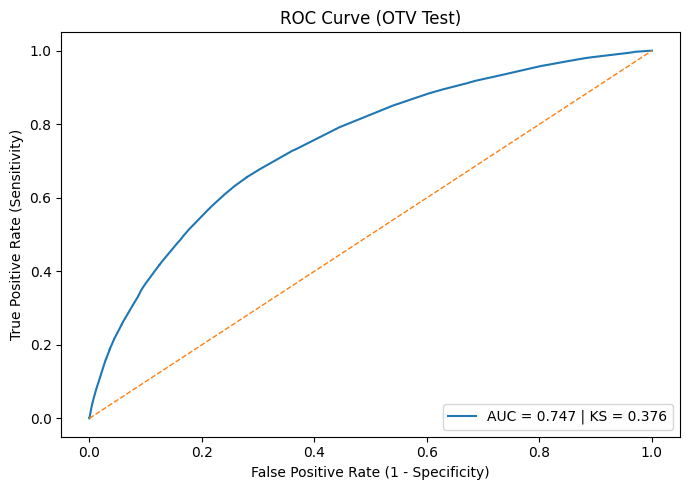

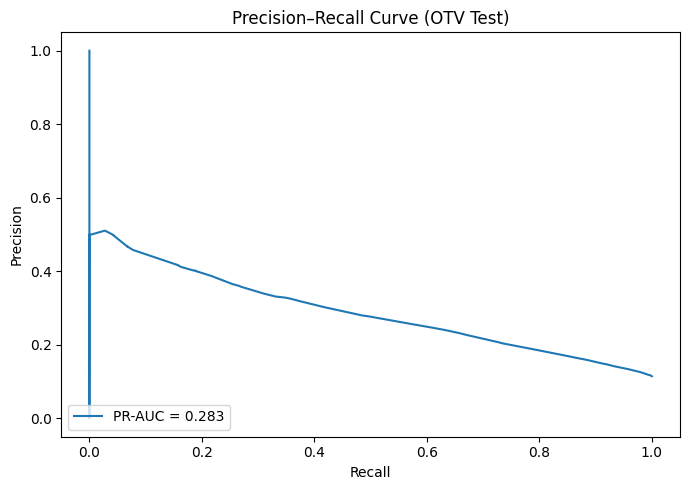

In [62]:
# --- ROC / AUC (OTV test) + PR curve, robust to missing globals ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# ---- helpers / safe fallbacks ----
def _get(name, default=None):
    return globals()[name] if name in globals() else default

prober = _get("prober", _get("clf"))               # fallback to raw model if no calibrated model
prior_adjust = bool(_get("prior_adjust", False))   # default off
X_test = _get("X_test")
y_test = _get("y_test")
y_train = _get("y_train", None)

if prober is None or X_test is None or y_test is None:
    raise RuntimeError("Need prober/clf, X_test, and y_test defined before running ROC/PR plotting.")


# ---- 1) get test-set probabilities consistent with the app's settings ----
y_prob_test = prober.predict_proba(X_test)[:, 1]

# Optional: prior/base-rate adjustment for the test window
if prior_adjust:
    pi_train = (float(y_train.mean()) if y_train is not None else float(y_test.mean()))
    pi_app   = float(y_test.mean())
    # Expect prior_shift_adjust(p, pi_train, pi_app) to exist in your env
    y_prob_test = prior_shift_adjust(y_prob_test, pi_train=pi_train, pi_app=pi_app)

# ---- 2) ROC curve (guard against single-class test) ----
fig_roc = plt.figure(figsize=(7, 5))
if len(np.unique(y_test)) > 1:
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    auc_val = roc_auc_score(y_test, y_prob_test)
    ks = float(np.max(tpr - fpr))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f} | KS = {ks:.3f}")
else:
    plt.plot([0, 1], [0, 1], label="Only one class in y_test")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (OTV Test)")
plt.legend(loc="lower right")

# Show ROC plot
plt.tight_layout()
plt.show()

# ---- 3) Precision–Recall curve (more informative with class imbalance) ----
fig_pr = plt.figure(figsize=(7, 5))
if len(np.unique(y_test)) > 1:
    prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
    ap = average_precision_score(y_test, y_prob_test)
    plt.plot(rec, prec, label=f"PR-AUC = {ap:.3f}")
else:
    base = float(np.mean(y_test))
    plt.plot([0, 1], [base, base], label="Only one class in y_test")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OTV Test)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [63]:
# ============================================================================
# MONOTONIC CONSTRAINT INFERENCE REPORT
# ============================================================================

# Create detailed report showing constraint for each feature
constraint_report = []

for feature, constraint in zip(feature_cols, monotonic_cst):
    # Determine source
    if feature in explicit_constraints:
        source = "Explicit"
        reason = "Manually defined"
    else:
        source = "Inferred"
        fname = feature.lower()
        
        # Show which pattern matched
        if any(word in fname for word in ['delinq', 'late', 'default', 'nsf', 'bounce']):
            reason = "Pattern: delinq/late/default"
        elif any(word in fname for word in ['balance', 'income', 'age', 'salary', 'deposit']):
            reason = "Pattern: balance/income/age"
        elif any(word in fname for word in ['daysbetween', 'gap', 'irregular']):
            reason = "Pattern: days between/gap"
        else:
            reason = "No pattern match"
    
    # Interpret constraint
    if constraint == -1:
        direction = "Negative (↑ feature → ↓ risk)"
        meaning = "Higher values = Safer"
    elif constraint == +1:
        direction = "Positive (↑ feature → ↑ risk)"
        meaning = "Higher values = Riskier"
    else:
        direction = "None (unconstrained)"
        meaning = "No monotonic assumption"
    
    constraint_report.append({
        'Feature': feature,
        'Constraint': constraint,
        'Direction': direction,
        'Meaning': meaning,
        'Source': source,
        'Reason': reason
    })

# Create DataFrame
constraint_df = pd.DataFrame(constraint_report)

# Summary statistics
print("=" * 100)
print("MONOTONIC CONSTRAINT SUMMARY")
print("=" * 100)
print(f"\nTotal Features: {len(feature_cols)}")
print(f"  • Negative constraints (-1): {sum(c == -1 for c in monotonic_cst)} features")
print(f"  • Positive constraints (+1): {sum(c == +1 for c in monotonic_cst)} features")
print(f"  • Unconstrained (0):         {sum(c == 0 for c in monotonic_cst)} features")

# Breakdown by source
explicit_count = constraint_df[constraint_df['Source'] == 'Explicit'].shape[0]
inferred_count = constraint_df[constraint_df['Source'] == 'Inferred'].shape[0]
print(f"\n  • Explicitly defined:        {explicit_count} features")
print(f"  • Auto-inferred:             {inferred_count} features")

# Show all explicit constraints
print("\n" + "=" * 100)
print("EXPLICIT CONSTRAINTS (manually defined)")
print("=" * 100)
explicit_df = constraint_df[constraint_df['Source'] == 'Explicit']
print(explicit_df[['Feature', 'Constraint', 'Direction', 'Meaning']].to_string(index=False))

# Show negative constraints (safer)
print("\n" + "=" * 100)
print("NEGATIVE CONSTRAINTS (-1): Higher Value = Safer")
print("=" * 100)
negative_df = constraint_df[constraint_df['Constraint'] == -1]
print(negative_df[['Feature', 'Source', 'Reason']].head(20).to_string(index=False))
if len(negative_df) > 20:
    print(f"... and {len(negative_df) - 20} more")

# Show positive constraints (riskier)
print("\n" + "=" * 100)
print("POSITIVE CONSTRAINTS (+1): Higher Value = Riskier")
print("=" * 100)
positive_df = constraint_df[constraint_df['Constraint'] == +1]
print(positive_df[['Feature', 'Source', 'Reason']].head(20).to_string(index=False))
if len(positive_df) > 20:
    print(f"... and {len(positive_df) - 20} more")

# Show unconstrained features
print("\n" + "=" * 100)
print("UNCONSTRAINED (0): No Monotonic Assumption")
print("=" * 100)
unconstrained_df = constraint_df[constraint_df['Constraint'] == 0]
print(unconstrained_df[['Feature', 'Source', 'Reason']].head(20).to_string(index=False))
if len(unconstrained_df) > 20:
    print(f"... and {len(unconstrained_df) - 20} more")

print("\n" + "=" * 100)
print("FULL TABLE (first 30 features)")
print("=" * 100)
print(constraint_df[['Feature', 'Constraint', 'Direction', 'Source']].head(30).to_string(index=False))
if len(constraint_df) > 30:
    print(f"\n... and {len(constraint_df) - 30} more features")

# Return the full dataframe for interactive viewing
print("\n" + "=" * 100)
print("💡 TIP: The variable 'constraint_df' contains the full report")
print("    You can view/filter it: constraint_df[constraint_df['Constraint'] == -1]")
print("=" * 100)

constraint_df


MONOTONIC CONSTRAINT SUMMARY

Total Features: 107
  • Negative constraints (-1): 4 features
  • Positive constraints (+1): 3 features
  • Unconstrained (0):         100 features

  • Explicitly defined:        7 features
  • Auto-inferred:             100 features

EXPLICIT CONSTRAINTS (manually defined)
                               Feature  Constraint                     Direction                 Meaning
                    accountageinmonths          -1 Negative (↑ feature → ↓ risk)   Higher values = Safer
  averagedaysbetweenincometransactions           1 Positive (↑ feature → ↑ risk) Higher values = Riskier
                         averageincome          -1 Negative (↑ feature → ↓ risk)   Higher values = Safer
                        currentbalance          -1 Negative (↑ feature → ↓ risk)   Higher values = Safer
                    xdayaveragebalance          -1 Negative (↑ feature → ↓ risk)   Higher values = Safer
  washighlydelinquentwithlastrepayment           1 Positive (↑ f

,Feature,Constraint,Direction,Meaning,Source,Reason
0,accountageinmonths,-1,Negative (↑ feature → ↓ risk),Higher values = Safer,Explicit,Manually defined
1,averagedaysbetweenincometransactions,1,Positive (↑ feature → ↑ risk),Higher values = Riskier,Explicit,Manually defined
2,averageincome,-1,Negative (↑ feature → ↓ risk),Higher values = Safer,Explicit,Manually defined
3,currentbalance,-1,Negative (↑ feature → ↓ risk),Higher values = Safer,Explicit,Manually defined
4,xdayaveragebalance,-1,Negative (↑ feature → ↓ risk),Higher values = Safer,Explicit,Manually defined
...,...,...,...,...,...,...
102,plaid_transaction_batch_feature_view__transact...,0,None (unconstrained),No monotonic assumption,Inferred,No pattern match
103,cash_advance_batch_feature_view__repayment_cou...,0,None (unconstrained),No monotonic assumption,Inferred,No pattern match
104,cash_advance_batch_feature_view__status_repaid...,0,None (unconstrained),No monotonic assumption,Inferred,No pattern match
105,washighlydelinquentwithlastrepayment,1,Positive (↑ feature → ↑ risk),Higher values = Riskier,Explicit,Manually defined


In [64]:
# # --- ROC / AUC (OTV test) + PR curve, using calibrated / prior-adjusted probs if enabled ---
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score

# # 1) get test-set probabilities consistent with the app's settings
# y_prob_test = prober.predict_proba(X_test)[:, 1]
# if prior_adjust:
#     y_prob_test = prior_shift_adjust(y_prob_test, pi_train=y_train.mean(), pi_app=y_test.mean())

# # 2) ROC curve (guard against single-class test)
# fig_roc = plt.figure(figsize=(7, 5))
# if len(np.unique(y_test)) > 1:
#     fpr, tpr, _ = roc_curve(y_test, y_prob_test)
#     auc_val = roc_auc_score(y_test, y_prob_test)
#     # KS statistic (optional but handy)
#     ks = np.max(tpr - fpr)
#     plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f} | KS = {ks:.3f}")
# else:
#     # degenerate case
#     plt.plot([0, 1], [0, 1], label="Only one class in y_test")

# plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.title("ROC Curve (OTV Test)")
# plt.legend(loc="lower right")
# # plt.tight_layout()
# st.pyplot(fig_roc, clear_figure=True)

# # 3) Precision-Recall curve (more informative with class imbalance)
# fig_pr = plt.figure(figsize=(7, 5))
# if len(np.unique(y_test)) > 1:
#     prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
#     ap = average_precision_score(y_test, y_prob_test)
#     plt.plot(rec, prec, label=f"PR-AUC = {ap:.3f}")
# else:
#     plt.plot([0, 1], [y_test.mean(), y_test.mean()], label="Only one class in y_test")

# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision–Recall Curve (OTV Test)")
# plt.legend(loc="lower left")
# # plt.tight_layout()
# st.pyplot(fig_pr, clear_figure=True)


Note: This is an interpretable approximation of the monotone HGBT. Node values are mean predicted probabilities.


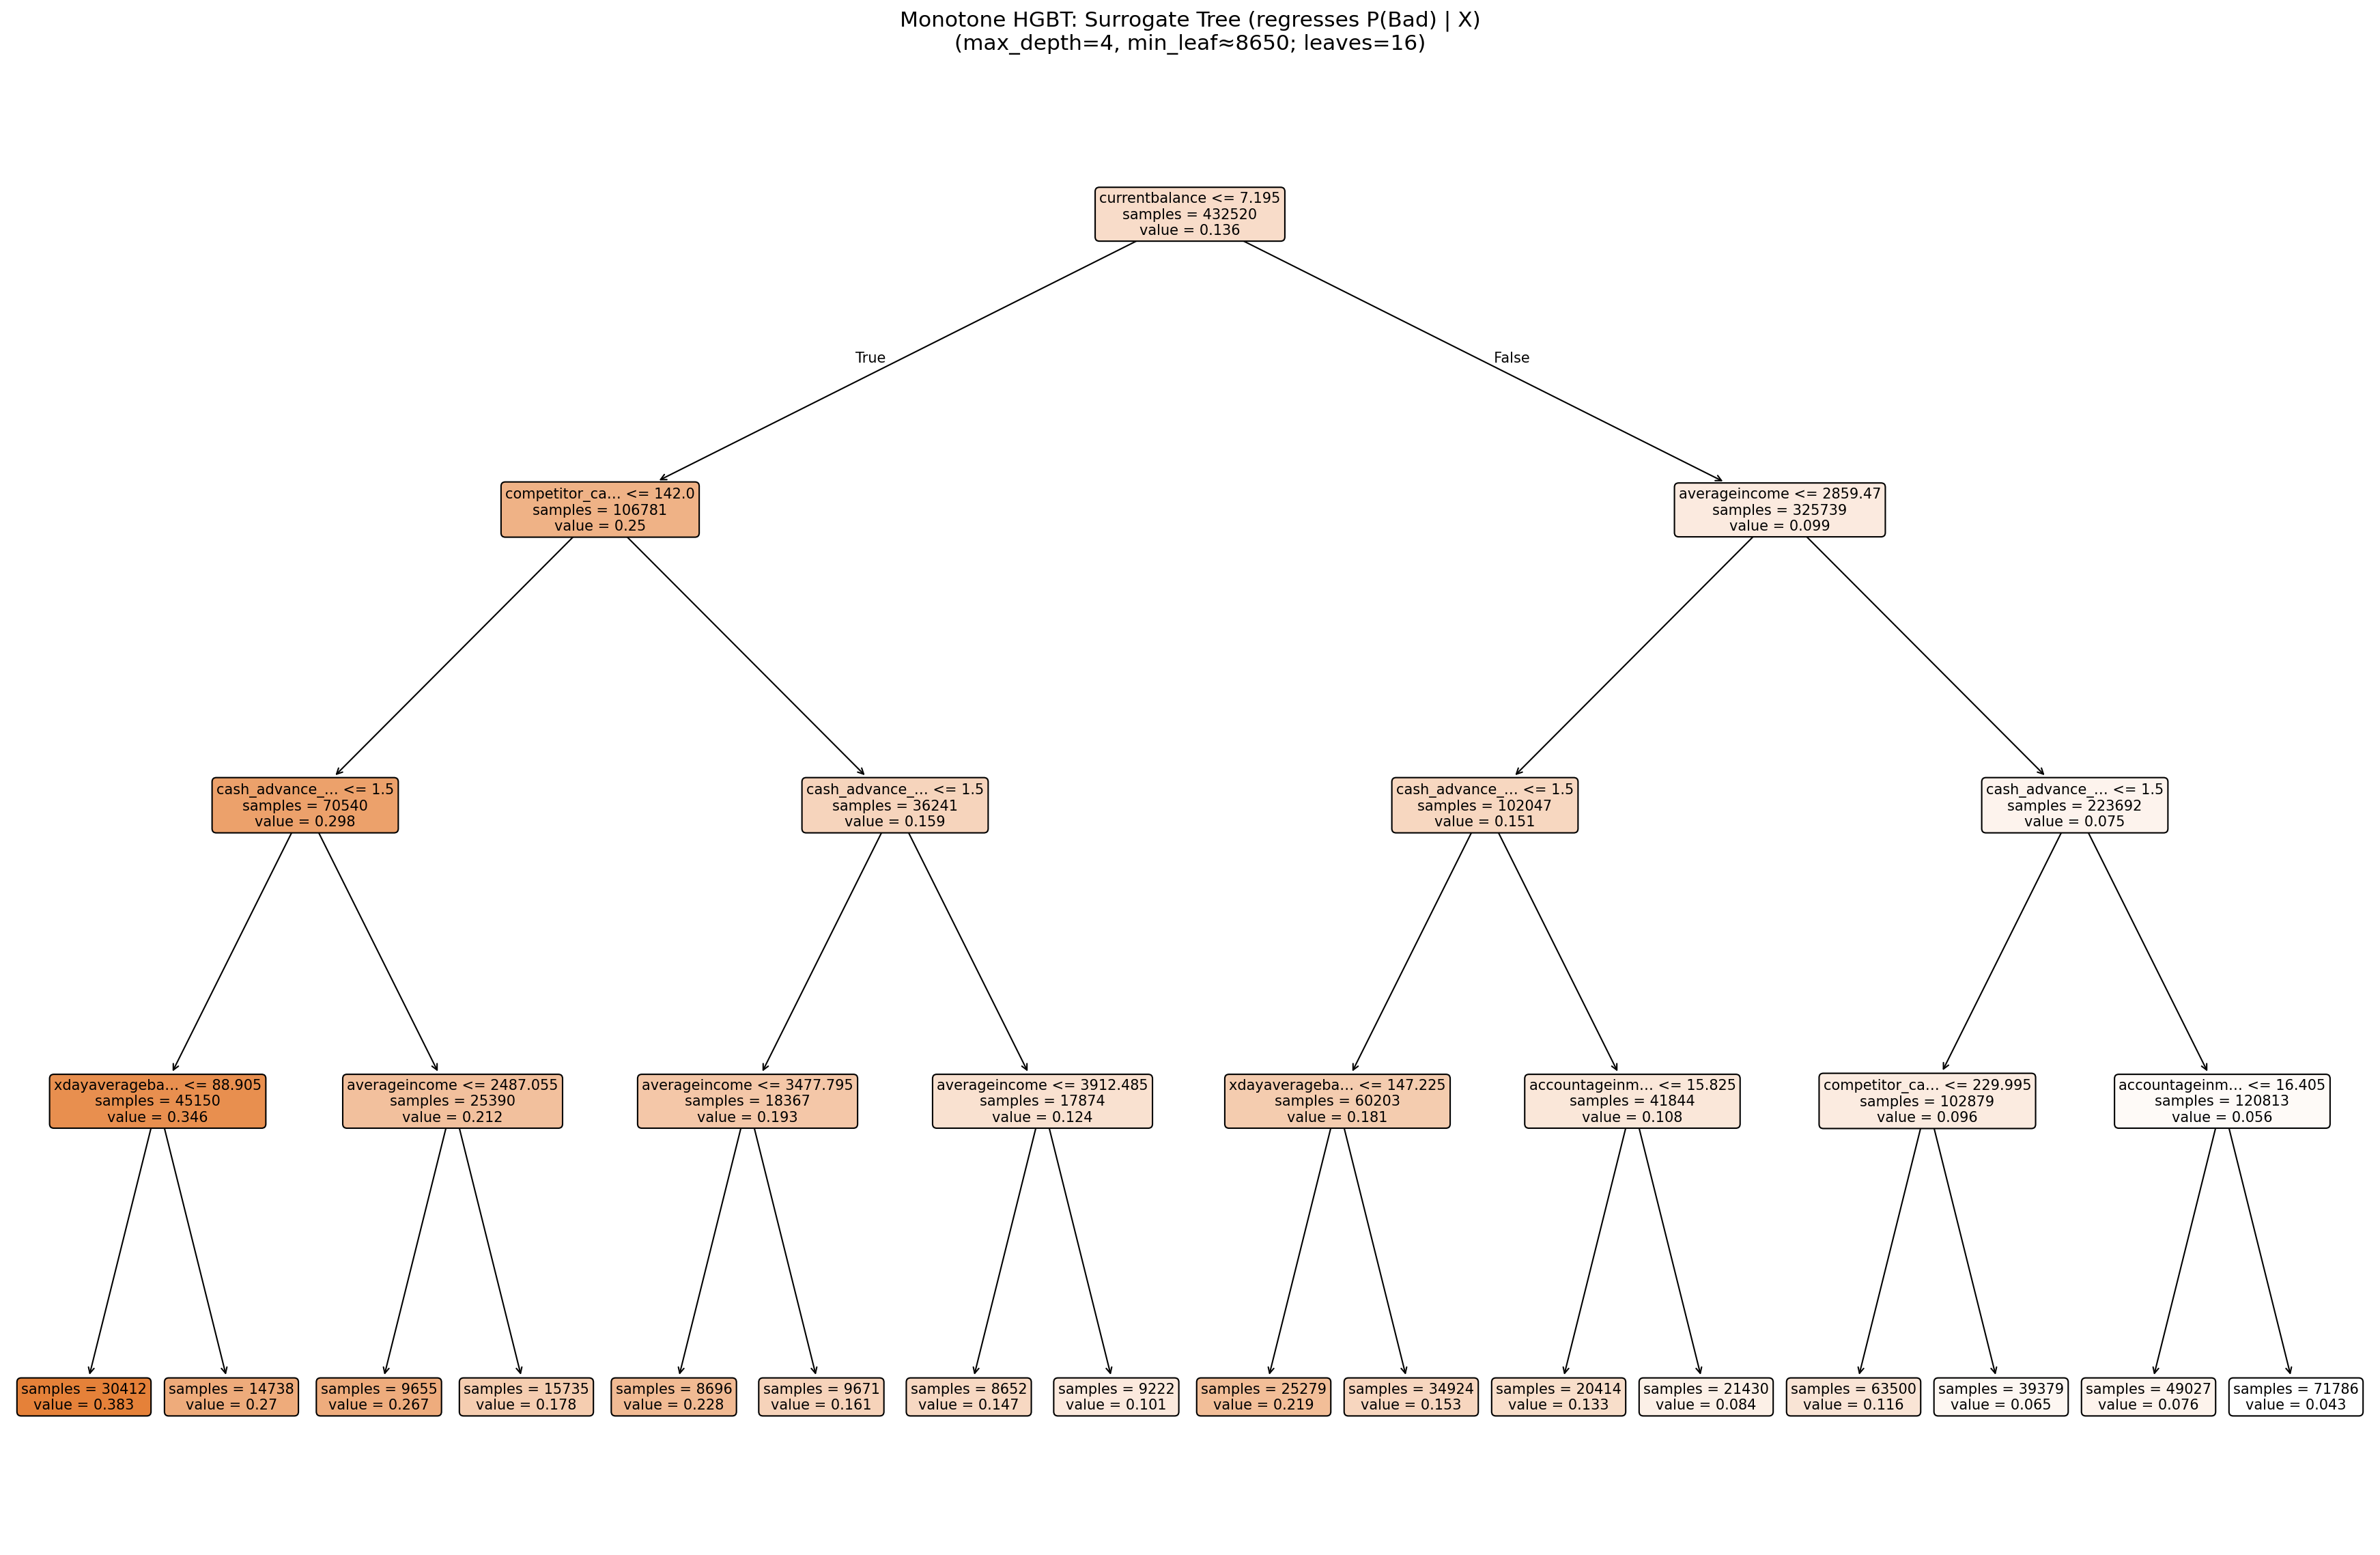

In [65]:
from sklearn.tree import plot_tree, DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

# --- helper: shorten long feature names for display only ---
def shorten(n, maxlen=14):
    return n if len(n) <= maxlen else n[:maxlen-1] + "…"

display_feature_names = [shorten(c, 14) for c in feature_cols]

def plot_model_tree_or_surrogate(estimator, X, prober=None, title_prefix="Model"):
    """
    If `estimator` is a single sklearn DecisionTree, plot it directly.
    Otherwise (e.g., HistGradientBoostingClassifier), train a shallow
    surrogate DecisionTreeRegressor on predicted probabilities and plot that.
    """
    is_single_tree = hasattr(estimator, "get_n_leaves") and hasattr(estimator, "tree_")

    if is_single_tree:
        # ---- Native decision tree plotting ----
        n_leaves = estimator.get_n_leaves()
        depth = estimator.get_depth()
        display_depth = min(depth, 4)  # adjust if you want more detail

        width  = max(24, min(96, 0.55 * n_leaves + 8))
        height = max(14, min(60, 2.60 * display_depth + 5))

        if n_leaves < 60:   fs = 12
        elif n_leaves < 140: fs = 8
        else:                fs = 6

        fig, ax = plt.subplots(figsize=(width, height), dpi=150)
        plot_tree(
            estimator,
            feature_names=display_feature_names,
            class_names=["good (0)","bad (1)"],
            max_depth=display_depth,   # cap drawn depth to avoid overlaps
            filled=True,
            rounded=True,
            proportion=True,
            impurity=False,
            precision=2,
            fontsize=fs,
            ax=ax,
        )
        ax.set_title(f"{title_prefix}: Decision Tree (drawn depth={display_depth}, "
                     f"full depth={depth}, leaves={n_leaves})", fontsize=15, pad=12)
        plt.subplots_adjust(left=0.02, right=0.98, top=0.92, bottom=0.02)
        plt.show()
    else:
        # ---- Surrogate tree on predicted probabilities ----
        # Use calibrated/probability-producing model if provided
        scorer = prober if prober is not None else estimator
        p_hat = scorer.predict_proba(X)[:, 1]

        # Shallow surrogate to reduce overlap and keep it readable
        min_leaf_abs = max(50, int(0.02 * len(X)))  # at least ~2% or 50 rows
        surrogate = DecisionTreeRegressor(
            max_depth=4, min_samples_leaf=min_leaf_abs, random_state=42
        ).fit(X, p_hat)

        # Estimate complexity for sizing
        try:
            n_leaves = surrogate.get_n_leaves()
            depth = surrogate.get_depth()
        except Exception:
            n_leaves, depth = 16, 4

        width  = max(24, min(96, 0.55 * n_leaves + 10))
        height = max(14, min(60, 2.60 * depth + 6))
        fs = 10 if n_leaves < 120 else 8

        fig, ax = plt.subplots(figsize=(width, height), dpi=150)
        plot_tree(
            surrogate,
            feature_names=display_feature_names,
            filled=True,
            rounded=True,
            impurity=False,
            precision=3,          # show mean predicted prob per node
            fontsize=fs,
            ax=ax,
        )
        ax.set_title(f"{title_prefix}: Surrogate Tree (regresses P(Bad) | X)\n"
                     f"(max_depth=4, min_leaf≈{min_leaf_abs}; leaves={n_leaves})",
                     fontsize=15, pad=12)
        plt.subplots_adjust(left=0.02, right=0.98, top=0.90, bottom=0.02)
        print("Note: This is an interpretable approximation of the monotone HGBT. "
              "Node values are mean predicted probabilities.")
        plt.show()

# ---- call it ----
# If you’re using HGBT + calibrator from earlier code, pass both:
plot_model_tree_or_surrogate(clf, X, prober=prober, title_prefix="Monotone HGBT")


In [66]:
# =============================
# Helper: build leaf descriptions
# =============================
from sklearn.tree import _tree

def build_leaf_rule_map(clf, feature_names, flag_features=None, round_digits=2):
    """
    Returns {leaf_id: 'COND1 & COND2 & ...'} for every leaf in clf.
    - flag_features: set/list of 0/1 features to render as Yes/No when split at 0.5
    """
    flag_features = set(flag_features or [])
    tree = clf.tree_
    children_left  = tree.children_left
    children_right = tree.children_right
    feature_idx    = tree.feature
    thresholds     = tree.threshold

    # parents & side (left/right) maps
    parent = {0: -1}
    is_left = {0: None}
    stack = [0]
    while stack:
        node = stack.pop()
        left, right = children_left[node], children_right[node]
        if left != _tree.TREE_LEAF:
            parent[left] = node;  is_left[left] = True;  stack.append(left)
        if right != _tree.TREE_LEAF:
            parent[right] = node; is_left[right] = False; stack.append(right)

    # find leaves
    leaves = [i for i in range(tree.node_count)
              if children_left[i] == _tree.TREE_LEAF and children_right[i] == _tree.TREE_LEAF]

    # build rule for each leaf by walking to root
    rule_map = {}
    for leaf in leaves:
        conds = []
        node = leaf
        while parent[node] != -1:
            p = parent[node]
            feat = feature_names[feature_idx[p]]
            thr  = thresholds[p]

            # pretty print thresholds
            thr_str = f"{thr:.{round_digits}f}"

            if feat in flag_features and abs(thr - 0.5) < 1e-6:
                # 0/1 flag split rendered as Yes/No
                if is_left[node]:  # <= 0.5
                    conds.append(f"{feat} = No")
                else:              # > 0.5
                    conds.append(f"{feat} = Yes")
            else:
                if is_left[node]:
                    conds.append(f"{feat} ≤ {thr_str}")
                else:
                    conds.append(f"{feat} > {thr_str}")

            node = p

        # reverse to go root -> leaf
        rule_map[leaf] = " and ".join(reversed(conds))
    return rule_map



RANK ORDER BY BRANCH (OBSERVED DELINQUENCY)
 LEAF_ID  rows  bad_rate  p_bad_avg  cum_share_pct                                                                                                                                                                                                                                                                branch_description
       5 15993    0.3605     0.4144            3.7                                                                currentbalance ≤ 7.19 and competitor_cash_advance_repayment_batch_feature_view__amt_all_advance_repay_120d ≤ 515.93 and xdayaveragebalance ≤ 88.88 and cash_advance_batch_feature_view__repayment_count_180d > inf
       4 17748    0.2887     0.3080            7.8                                                                currentbalance ≤ 7.19 and competitor_cash_advance_repayment_batch_feature_view__amt_all_advance_repay_120d ≤ 515.93 and xdayaveragebalance ≤ 88.88 and cash_advance_batch_feature_view__repayme

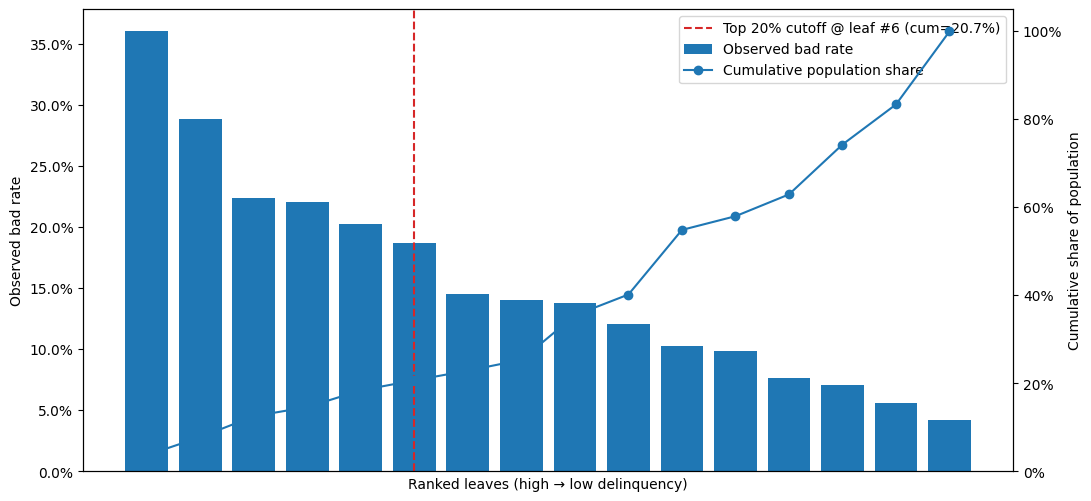

In [67]:
# --- Ensure LEAF_ID exists (direct tree or surrogate) ---

# 1) Make sure P_BAD is on the full data (aligns with your "prober" if used)
if "P_BAD" not in pdf.columns:
    prober_full = prober if "prober" in globals() and prober is not None else clf
    pdf["P_BAD"] = pd.Series(prober_full.predict_proba(X)[:, 1], index=pdf.index)

# 2) Try to get leaf ids from the actual tree; else fit a shallow surrogate tree on P_BAD
if hasattr(clf, "apply") and hasattr(clf, "tree_"):
    # Single sklearn DecisionTreeClassifier
    pdf["LEAF_ID"] = clf.apply(X)
    tree_for_rules = clf
else:
    # Build a small surrogate tree to create stable, interpretable segments
    from sklearn.tree import DecisionTreeRegressor
    min_leaf_abs = max(50, int(0.02 * len(X)))  # ~2% or at least 50 rows per leaf
    surrogate = DecisionTreeRegressor(
        max_depth=4,
        min_samples_leaf=min_leaf_abs,
        random_state=42
    ).fit(X, pdf["P_BAD"])
    pdf["LEAF_ID"] = surrogate.apply(X)
    tree_for_rules = surrogate  # use this if you want to try to extract simple rules

# --- Now your per-leaf summary works ---
leaf_summary = (
    pdf.groupby("LEAF_ID")
      .agg(
          rows=("advanceid", "count"),
          bad_rate=("BAD_28D", "mean"),
          p_bad_avg=("P_BAD", "mean"),
      )
      .reset_index()
)

# Rank leaves by observed bad rate (break ties by size)
leaf_ranked = (
    leaf_summary.sort_values(["bad_rate", "rows"], ascending=[False, False])
                .reset_index(drop=True)
)

# Optional: add human-readable rules if you have a helper for classification trees.
# For a surrogate regressor, you can skip or adapt your rule-extraction.
try:
    flag_feats = {
        "WASHIGHLYDELINQUENTWITHLASTREPAYMENT",
        "WASSEVERELYDELINQUENTWITHLASTREPAYMENT",
    }
    leaf_rules = build_leaf_rule_map(
        tree_for_rules,
        feature_names=list(X.columns),
        flag_features=flag_feats,
        round_digits=2
    )
    leaf_ranked["branch_description"] = leaf_ranked["LEAF_ID"].map(leaf_rules)
except Exception:
    # Fallback: no rules available
    leaf_ranked["branch_description"] = "(rules unavailable for this model type)"

# Cumulative population share & 20% cutoff
total_rows = int(leaf_ranked["rows"].sum())
leaf_ranked["share"] = leaf_ranked["rows"] / total_rows
leaf_ranked["cum_share"] = leaf_ranked["share"].cumsum()
target_share = 0.20
cut_idx = int((leaf_ranked["cum_share"] >= target_share).idxmax())
cut_share = leaf_ranked.loc[cut_idx, "cum_share"]

# Show table
print("\n" + "="*50)
print("RANK ORDER BY BRANCH (OBSERVED DELINQUENCY)")
print("="*50)
display_df = leaf_ranked.assign(
    bad_rate=lambda d: d["bad_rate"].round(4),
    p_bad_avg=lambda d: d["p_bad_avg"].round(4),
    cum_share_pct=lambda d: (d["cum_share"]*100).round(1),
)[["LEAF_ID","rows","bad_rate","p_bad_avg","cum_share_pct","branch_description"]]
print(display_df.to_string(index=False))

# Plot rank-ordered leaves with 20% cutoff
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(leaf_ranked))

ax1.bar(x, leaf_ranked["bad_rate"], label="Observed bad rate")
ax1.set_ylabel("Observed bad rate")
ax1.set_xlabel("Ranked leaves (high → low delinquency)")
ax1.set_xticks([])
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))

ax2 = ax1.twinx()
ax2.plot(x, leaf_ranked["cum_share"], marker="o", linestyle="-", label="Cumulative population share")
ax2.set_ylabel("Cumulative share of population")
ax2.set_ylim(0, 1.05)
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

ax1.axvline(
    cut_idx, linestyle="--",
    label=f"Top 20% cutoff @ leaf #{cut_idx+1} (cum={cut_share:.1%})",
    color="tab:red"
)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.show()

# Slice: worst 20% of population (by observed bad-rate ranking)
top20 = leaf_ranked.loc[:cut_idx].copy()


In [68]:

print("n_test:", len(y_test))
print("unique y_pred:", pd.Series(y_prob_test).nunique())
print("label balance:", pd.Series(y_test).value_counts(normalize=True))
print("AUC:", roc_auc_score(y_test, y_prob_test))


n_test: 106479
unique y_pred: 161
label balance: BAD_28D
0    0.885555
1    0.114445
Name: proportion, dtype: float64
AUC: 0.7473086072023714


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import roc_curve

def pav_monotone_per_bin(events, pop, increasing=True):
    events = np.asarray(events, dtype=float)
    pop    = np.asarray(pop,    dtype=float)
    blocks_y = events.tolist()
    blocks_n = pop.tolist()
    blocks_k = [1] * len(events)

    def rate(i): return blocks_y[i] / max(blocks_n[i], 1.0)

    i = 0
    while i < len(blocks_y) - 1:
        r1, r2 = rate(i), rate(i+1)
        bad = (r1 > r2) if increasing else (r1 < r2)
        if bad:
            blocks_y[i] += blocks_y[i+1]
            blocks_n[i] += blocks_n[i+1]
            blocks_k[i] += blocks_k[i+1]
            del blocks_y[i+1]; del blocks_n[i+1]; del blocks_k[i+1]
            if i > 0: i -= 1
        else:
            i += 1

    out = []
    for yb, nb, kb in zip(blocks_y, blocks_n, blocks_k):
        rb = yb / max(nb, 1.0)
        out.extend([rb] * kb)
    return np.array(out, dtype=float)

def create_gains_lift_table_no_opt(y_true, y_pred, n_bins=10, enforce_monotone=True):
    """
    Quantile-binned gains table with optional PAV smoothing of observed event rates.
    Also draws a chart and returns the 20% cumulative-population cutoff.
    """
    # --- align & clean ---
    y_true = pd.Series(y_true, name="y_true").astype(int).reset_index(drop=True)
    y_pred = pd.Series(y_pred, name="y_pred").astype(float).reset_index(drop=True)
    df = pd.concat([y_true, y_pred], axis=1)
    df = df[np.isfinite(df["y_pred"])].copy()
    if df.empty:
        raise ValueError("No finite predictions in y_pred.")

    # --- quantile bins by rank (robust to ties) ---
    ranked = df["y_pred"].rank(method="first")
    q = int(min(n_bins, ranked.nunique()))
    q = max(q, 2)
    df["bin"] = pd.qcut(ranked, q=q, labels=False, duplicates="drop") + 1

    # --- aggregate per bin ---
    agg = (df.groupby("bin", as_index=True)
             .agg(population=("y_true","size"),
                  events=("y_true","sum"),
                  min_score=("y_pred","min"),
                  max_score=("y_pred","max"),
                  pred_event_rate=("y_pred","mean"))
             .sort_index())

    # observed event rate
    agg["event_rate"] = np.where(agg["population"] > 0,
                                 agg["events"] / agg["population"], 0.0)

    # optional monotone smoothing (higher bin = higher risk)
    if enforce_monotone and len(agg) > 1:
        agg["event_rate"] = pav_monotone_per_bin(
            agg["events"].values, agg["population"].values, increasing=True
        )

    # --- cumulative metrics / lift ---
    total_events = max(int(agg["events"].sum()), 1)
    total_pop    = max(int(agg["population"].sum()), 1)

    agg["pop_share"]   = agg["population"] / total_pop
    agg["cum_population"] = agg["population"].cumsum()
    agg["cum_events"]  = agg["events"].cumsum()
    agg["gain"]        = 100 * agg["cum_events"] / total_events
    agg["cum_pop_%"]   = 100 * agg["cum_population"] / total_pop
    agg["lift"]        = np.where(agg["cum_pop_%"] > 0, agg["gain"] / agg["cum_pop_%"], np.nan)

    # friendly bin labels
    agg["bin_summary"] = (
        agg.index.astype(int).astype(str) + ": [" +
        agg["min_score"].apply(lambda x: f"{x:.4f}") + " to " +
        agg["max_score"].apply(lambda x: f"{x:.4f}") + "]"
    )

    # --- find 20% cumulative population cutoff ---
    agg["cum_pop_share"] = agg["pop_share"].cumsum()
    if (agg["cum_pop_share"] >= 0.20).any():
        cutoff_row = agg.index[(agg["cum_pop_share"] >= 0.20)][0]
    else:
        cutoff_row = agg.index.max()
    cutoff_share = float(agg.loc[cutoff_row, "cum_pop_share"])

    # --- optional KS, handy to print/log ---
    try:
        fpr, tpr, _ = roc_curve(df["y_true"], df["y_pred"])
        ks = float(np.max(tpr - fpr))
    except Exception:
        ks = np.nan

    # --- plot ---
    fig, ax1 = plt.subplots(figsize=(12, 7))
    idx = agg.index.astype(int)

    # bars: population share
    ax1.bar(idx, agg["pop_share"], label="Population share")
    ax1.set_xlabel("Bins (low → high risk)")
    ax1.set_ylabel("Population share")
    ax1.set_xticks(idx)
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))

    # event rates (actual = red; predicted = dashed orange)
    ax2 = ax1.twinx()
    ax2.plot(idx, agg["event_rate"], marker="o", linestyle="-",
             color="tab:red", label="Actual event rate")
    ax2.plot(idx, agg["pred_event_rate"], marker="x", linestyle="--",
             color="tab:orange", label="Predicted event rate")
    ax2.set_ylabel("Event rate")
    ax2.set_ylim(0, 1.0)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

    # 20% cutoff line
    ax1.axvline(cutoff_row, linestyle="--",
                label=f"Top 20% cutoff @ bin {int(cutoff_row)} (cum={cutoff_share:.1%})")

    # legend
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax2.legend(l1 + l2, lab1 + lab2, loc="upper left")

    title_suffix = f" | KS={ks:.3f}" if not np.isnan(ks) else ""
    plt.title(f"Gains Chart (quantile bins; PAV-smoothed observed){title_suffix}")
    fig.tight_layout()

    cols = ["bin_summary","min_score","max_score","population","events",
            "pop_share","event_rate","pred_event_rate",
            "cum_population","cum_events","gain","lift","cum_pop_%","cum_pop_share"]
    table = agg[cols].reset_index().rename(columns={"index":"bin"})

    return table, fig, int(cutoff_row), cutoff_share

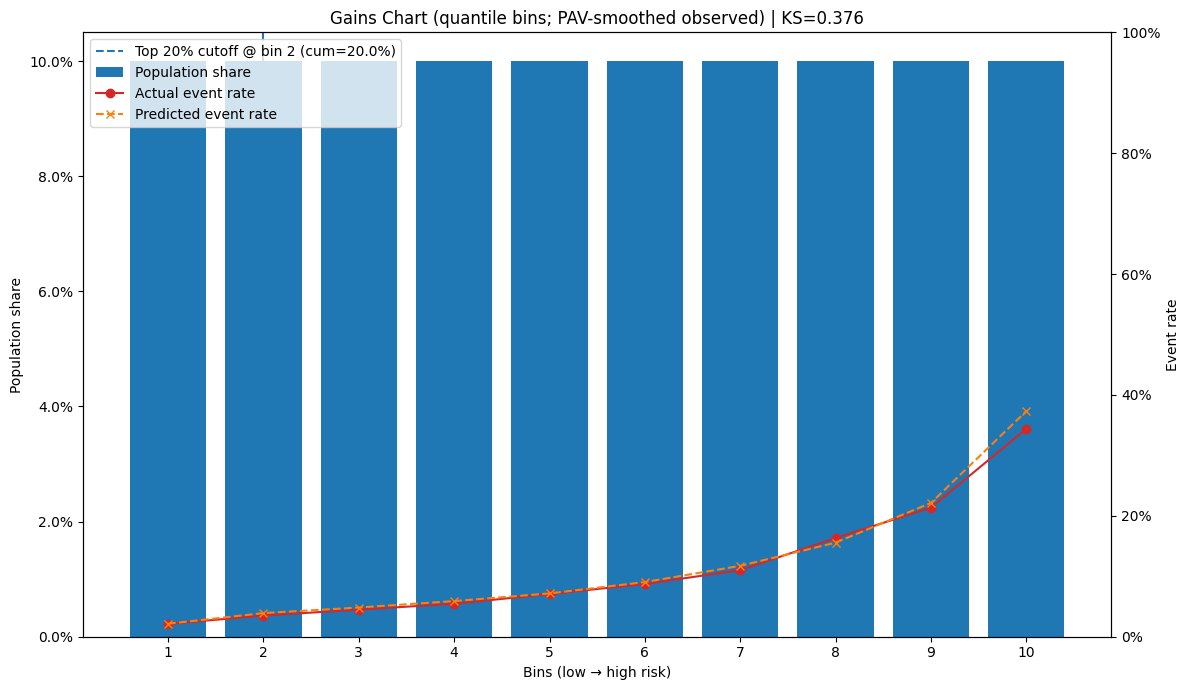

In [70]:
# --- call it (y_true/y_pred aligned to the same index) ---
y_prob_test = pd.Series(prober.predict_proba(X_test)[:, 1], index=y_test.index)

gains_df, fig, cutoff_bin, cutoff_share = create_gains_lift_table_no_opt(
    y_true=y_test, y_pred=y_prob_test, n_bins=10, enforce_monotone=True
)

plt.show()


In [85]:
# --- your function (unchanged) ---
def calc_iv(df, feature, target, pr=0):
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([
            feature, val,
            df[df[feature] == val].count()[feature],
            df[(df[feature] == val) & (df[target] == 1)].count()[feature]
        ])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]  # note: drops bins with 0 bads

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)
    if pr == 1:
        print(data)
    return data['IV'].values[0]

# --- helper to compute IVs for many columns ---
def compute_iv_all(df, features, target_col="BAD_28D", n_bins=10):
    iv_rows = []
    work = df.copy()

    for f in features:
        s = work[f]
        # If numeric with many unique values, bin first so calc_iv can work
        if pd.api.types.is_numeric_dtype(s) and s.nunique(dropna=True) > n_bins:
            # keep NaN as its own label
            notna = s.notna()
            # rank to break ties; duplicates='drop' avoids qcut errors
            bins = pd.qcut(
                s[notna].rank(method="first"),
                q=n_bins,
                duplicates="drop"
            )
            # label bins with ranges
            binned = pd.Series(index=s.index, dtype="object")
            binned[notna] = bins.astype(str).values
            binned[~notna] = "Missing"
            work[f + "_BIN"] = binned
            iv_val = calc_iv(work, f + "_BIN", target_col, pr=0)
            iv_rows.append({"feature": f, "iv": iv_val, "used_bins": work[f + "_BIN"].nunique()})
        else:
            # treat as categorical/flag
            s_cat = s.astype("object").where(s.notna(), "Missing")
            work[f + "_CAT"] = s_cat
            iv_val = calc_iv(work, f + "_CAT", target_col, pr=0)
            iv_rows.append({"feature": f, "iv": iv_val, "used_bins": work[f + "_CAT"].nunique()})

    iv_df = pd.DataFrame(iv_rows).sort_values("iv", ascending=False).reset_index(drop=True)
    return iv_df

# ---- run it on your dataset ----
# Uses the auto-detected feature_cols from earlier cells (includes ALL features)
print(f"Computing IV for {len(feature_cols)} features...")
print("This may take a moment for large datasets...\n")

iv_table = compute_iv_all(pdf, features=feature_cols, target_col="BAD_28D", n_bins=10)

print("\n" + "=" * 80)
print("INFORMATION VALUE (IV) RESULTS - ALL FEATURES")
print("=" * 80)
print(f"\nTop 20 features by IV:")
print(iv_table.head(20).to_string(index=False))

if len(iv_table) > 20:
    print(f"\n... and {len(iv_table) - 20} more features")

print("\n" + "=" * 80)
print("IV INTERPRETATION GUIDE")
print("=" * 80)
print("  < 0.02  : Unpredictive")
print("  0.02-0.1: Weak predictor")
print("  0.1-0.3 : Medium predictor")
print("  0.3-0.5 : Strong predictor")
print("  > 0.5   : Suspicious (potential overfitting/leakage)")

# Count by strength
weak = iv_table[(iv_table['iv'] >= 0.02) & (iv_table['iv'] < 0.1)].shape[0]
medium = iv_table[(iv_table['iv'] >= 0.1) & (iv_table['iv'] < 0.3)].shape[0]
strong = iv_table[(iv_table['iv'] >= 0.3) & (iv_table['iv'] < 0.5)].shape[0]
suspicious = iv_table[iv_table['iv'] >= 0.5].shape[0]
unpredictive = iv_table[iv_table['iv'] < 0.02].shape[0]

print(f"\nFeature Strength Summary:")
print(f"  Unpredictive (< 0.02):    {unpredictive} features")
print(f"  Weak (0.02-0.1):          {weak} features")
print(f"  Medium (0.1-0.3):         {medium} features")
print(f"  Strong (0.3-0.5):         {strong} features")
print(f"  Suspicious (> 0.5):       {suspicious} features")

if suspicious > 0:
    print(f"\n⚠️  WARNING: {suspicious} feature(s) with IV > 0.5 detected (possible data leakage):")
    print(iv_table[iv_table['iv'] >= 0.5][['feature', 'iv']].to_string(index=False))

print("\n💡 TIP: Variable 'iv_table' contains full results. Use iv_table.to_csv('iv_results.csv') to save")

iv_table.to_csv('iv_results.csv')

Computing IV for 107 features...
This may take a moment for large datasets...



/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/763660999.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  work[f + "_BIN"] = binned
/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/763660999.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  work[f + "_BIN"] = binned
/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/763660999.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance


INFORMATION VALUE (IV) RESULTS - ALL FEATURES

Top 20 features by IV:
                                                                         feature       iv  used_bins
                                                                  currentbalance 0.304260         10
                                                              xdayaveragebalance 0.258189         10
                                                                   averageincome 0.232015         11
     competitor_cash_advance_taken_batch_feature_view__amt_all_advance_taken_10d 0.207553         11
     plaid_transaction_batch_feature_view__transaction_amount_positive_count_14d 0.197421         11
    competitor_cash_advance_taken_batch_feature_view__amt_all_advance_taken_120d 0.195501         11
                       cash_advance_batch_feature_view__status_repaid_count_180d 0.181467         11
competitor_cash_advance_repayment_batch_feature_view__amt_all_advance_repay_120d 0.180939         11
 competitor_cash_adv

In [72]:
import re

def make_month(df, date_col, tz=None):
    s = pd.to_datetime(df[date_col], errors="coerce")
    if tz:
        s = s.dt.tz_localize("UTC").dt.tz_convert(tz).dt.tz_localize(None)
    return s.dt.to_period("M").dt.to_timestamp()  # month start

def _format_edge(x, decimals=0):
    """
    Pretty-print a numeric edge with chosen decimals (default 0).
    Using 0 avoids long floats; increase to prevent [0, 0) style collapses.
    """
    fmt = f"{{:.{decimals}f}}"
    return fmt.format(x)

def bin_numeric(
    series,
    *,
    mode="quantile",     # 'quantile' (qcut) or 'custom' (cut with edges)
    q=10,                # number of quantile bins for mode='quantile'
    edges=None,          # list of custom edges for mode='custom' (without ±inf)
    right=False,         # interval closure for custom bins: [lo, hi) if False
    rounding_base=None,  # if set (e.g., 50), round label edges to this base
    label_prefix=""
):
    """
    Bin a numeric series into human-readable ranges.

    - Quantile mode: balanced-count bins via qcut (ties handled); labels built
      from value quantiles (optionally rounded) with strict monotonicity.
    - Custom mode: use provided edges with pd.cut (±inf added automatically).

    Returns
    -------
    binned : pd.Series of object labels (including 'Missing' for NaNs)
    labels_ordered : list[str] low→high ordered labels actually used
    """
    s = pd.to_numeric(series, errors="coerce")
    mask = s.notna() & np.isfinite(s)

    if mode == "custom":
        if edges is None:
            raise ValueError("Provide 'edges' when mode='custom'.")
        bins = [-np.inf] + list(edges) + [np.inf]
        cats = pd.cut(s[mask], bins=bins, right=right, include_lowest=True)
        labels_ordered = [str(iv) for iv in cats.cat.categories]  # already low→high
        code_to_label = dict(enumerate(labels_ordered))
        out = pd.Series(index=s.index, dtype="object")
        out[mask] = cats.cat.codes.map(code_to_label).values

    else:
        # Optional winsorization to tame extreme tails that cause huge top bins
        s_w = s.copy()
        if mask.any():
            lo, hi = np.nanpercentile(s_w[mask], [1, 99])
            s_w[mask] = np.clip(s_w[mask], lo, hi)

        ranked = s_w[mask].rank(method="first")
        codes, _ = pd.qcut(
            ranked,
            q=min(q, ranked.nunique()),
            labels=False,
            retbins=True,
            duplicates="drop",
        )

        if len(codes) == 0:
            out = pd.Series("Missing", index=s.index, dtype="object")
            return out, ["Missing"]

        n_bins = int(np.max(codes)) + 1
        # Exact quantile edges from (winsorized) values
        edges_raw = np.quantile(s_w[mask], np.linspace(0, 1, n_bins + 1))

        # Build label edges
        if rounding_base is None:
            edges_lbl = edges_raw.astype(float)
        else:
            edges_lbl = rounding_base * np.round(edges_raw / rounding_base)
            # ensure strict monotonicity after rounding to avoid [a, a)
            for i in range(1, len(edges_lbl)):
                if edges_lbl[i] <= edges_lbl[i - 1]:
                    edges_lbl[i] = edges_lbl[i - 1] + 1e-6

        labels_ordered = [
            f"{label_prefix}[{_format_edge(edges_lbl[i])}, {_format_edge(edges_lbl[i+1])})"
            for i in range(n_bins)
        ]

        mapper = dict(enumerate(labels_ordered))
        out = pd.Series(index=s.index, dtype="object")
        out[mask] = pd.Series(codes, index=s[mask].index).map(mapper).values

    out[~mask] = "Missing"
    out.name = series.name + "_BIN"
    return out.astype("object"), labels_ordered


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume make_month and bin_numeric helpers are defined elsewhere

def monthly_stacked_numeric(
    df,
    value_col,            # numeric to bin (e.g., "AVERAGEINCOME")
    date_col,             # timestamp (e.g., "CREATEDAT")
    target_col,           # 0/1 label (e.g., "BAD_28D")
    *,
    bin_mode="quantile",  # "quantile" or "custom"
    q=5,                  # <-- five quantile bins by default
    edges=None,           # list of cut edges if bin_mode="custom"
    right=False,          # interval closure for custom bins
    rounding_base=50,     # nice rounding for labels when quantile mode
    figsize=(16,10),
    alpha=0.65,
    title=None,
    annotation_fontsize=10 # <-- New parameter for font size
):
    work = df[[value_col, date_col, target_col]].copy()
    work["MONTH"] = make_month(work, date_col)

    # Assumes bin_numeric helper function exists
    work[value_col + "_BIN"], labels = bin_numeric(
        work[value_col],
        mode=bin_mode, q=q, edges=edges, right=right,
        rounding_base=rounding_base, label_prefix=""
    )
    ydim = value_col + "_BIN"

    # Data processing (no changes here)
    ne = (work[work[target_col]==0]
          .groupby([ydim,"MONTH"], dropna=False)[target_col].count()
          .rename("non_events").reset_index())
    ev = (work[work[target_col]==1]
          .groupby([ydim,"MONTH"], dropna=False)[target_col].count()
          .rename("events").reset_index())
    tot_m = (work.groupby("MONTH", dropna=False)[target_col]
             .count().rename("total_by_month").reset_index())
    res = ne.merge(ev, how="outer", on=[ydim,"MONTH"]).fillna(0)
    res["total"] = res["non_events"] + res["events"]
    res = res.merge(tot_m, on="MONTH", how="left")
    res["event_rate_%"] = np.where(res["total"]>0, 100*res["events"]/res["total"], 0.0)
    res["% dist"] = np.where(res["total_by_month"]>0, 100*res["total"]/res["total_by_month"], 0.0)
    
    # Pivot for stacked plot (no changes here)
    dist = (res.pivot(index=ydim, columns="MONTH", values="% dist")
              .fillna(0.0))
    er   = (res.pivot(index=ydim, columns="MONTH", values="event_rate_%")
              .reindex(index=dist.index, columns=dist.columns)
              .fillna(0.0))
    ordered = [lbl for lbl in labels if lbl in dist.index]
    if "Missing" in dist.index:
        ordered = [lbl for lbl in ordered if lbl != "Missing"] + ["Missing"]
    dist = dist.reindex(index=ordered)
    er   = er.reindex(index=ordered)

    cols_sorted = []
    try:
        cols_sorted = sorted(dist.columns, key=pd.to_datetime)
        dist = dist[cols_sorted]; er = er[cols_sorted]
    except Exception:
        pass

    # --- Plotting Section ---
    fig, ax = plt.subplots(figsize=figsize)
    dist.T.plot(kind="bar", stacked=True, rot=1, ax=ax, alpha=alpha)

    # ✅ CHANGE 2: Format the x-axis labels to 'YYYY-MM'
    ax.set_xticklabels([month.strftime('%Y-%m') for month in cols_sorted], rotation=45, ha="right")

    ax.set_ylabel("% Dist"); ax.set_xlabel("Month")
    ax.set_title(title or f"{value_col} bins (% dist, event rate) by Month")
    ax.grid(False)
    ax.legend(bbox_to_anchor=(1.0, 1.0), title=ydim)

    # --- Annotation Section ---
    vals_dist = dist.T.values
    vals_er   = er.T.values
    n_months, n_bins = vals_dist.shape
    for i, p in enumerate(ax.patches):
        h = p.get_height()
        if h <= 1e-3: continue
        x, y = p.get_xy(); w = p.get_width()

        month_idx = i % n_months
        bin_idx = i // n_months
        
        # ✅ CHANGE 1: Use the new fontsize parameter
        ax.text(x+w/2, y+h/2, f"{h:.1f}%,{vals_er[month_idx, bin_idx]:.1f}%",
                ha="center", va="center", fontsize=annotation_fontsize)

    fig.tight_layout()

    out = (res[["MONTH", ydim, "total", "events", "non_events", "event_rate_%", "% dist"]]
           .sort_values(["MONTH", ydim]).reset_index(drop=True))
    return out, fig, ax

/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1879273856.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period("M").dt.to_timestamp()  # month start


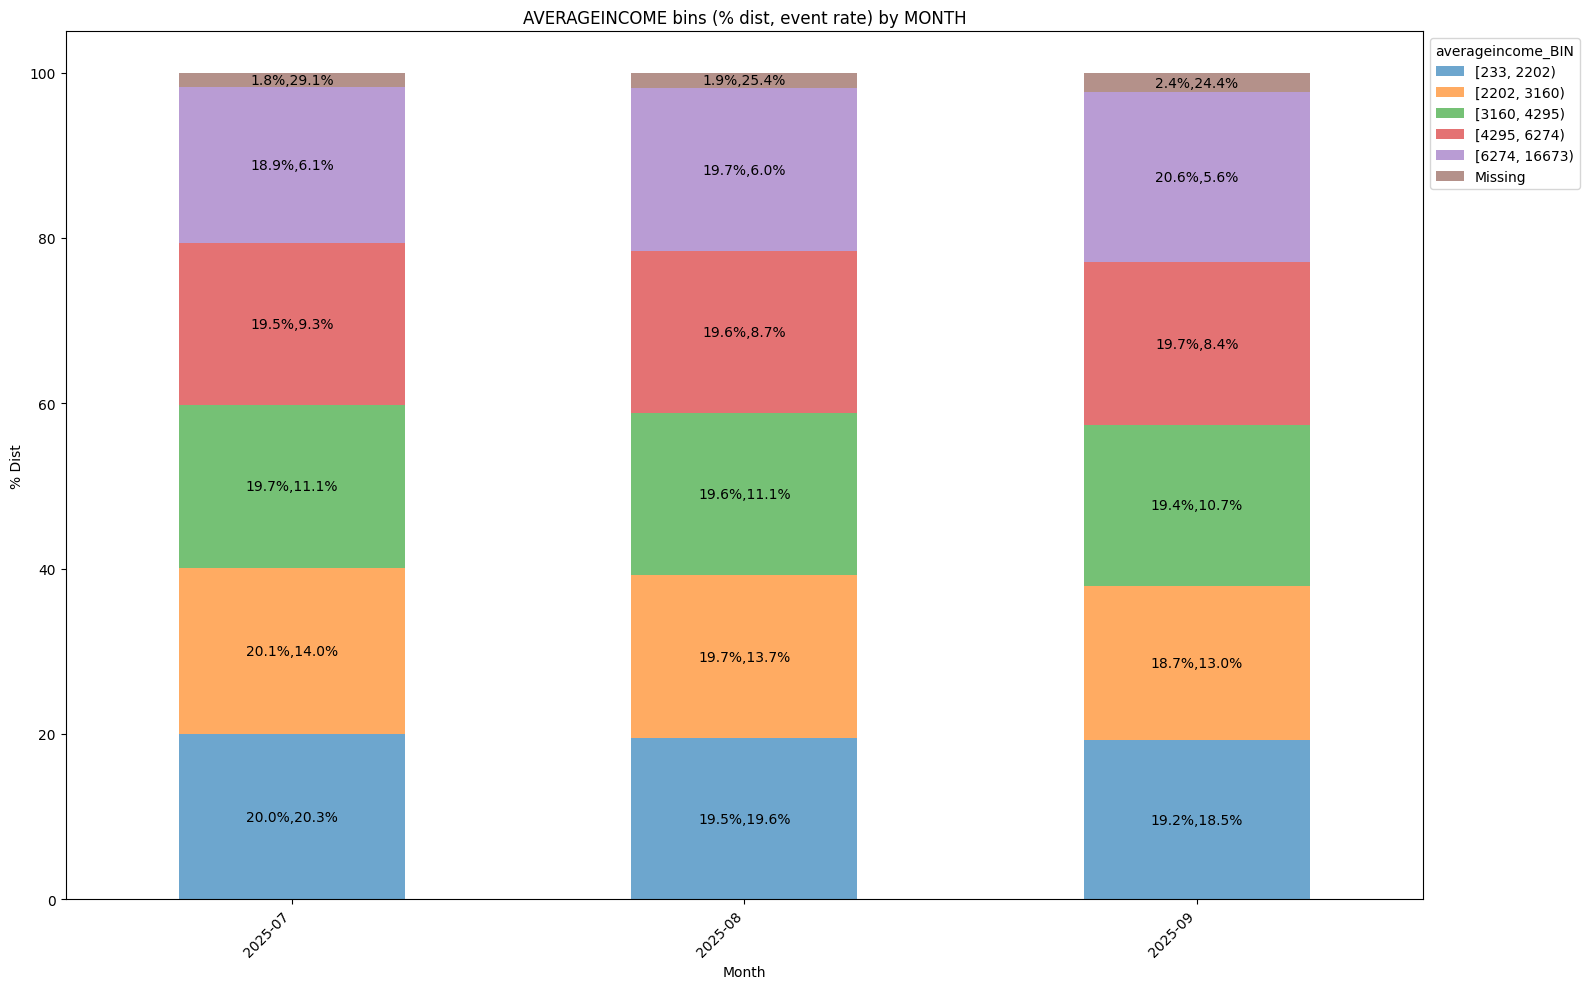

In [74]:
tbl_inc_m, fig_inc_m, ax_inc_m = monthly_stacked_numeric(
    pdf,
    value_col="averageincome",
    date_col="createdat",
    target_col="BAD_28D",
    bin_mode="quantile",  # or "custom" with edges=[...]
    q=5,
    rounding_base=1,
    title="AVERAGEINCOME bins (% dist, event rate) by MONTH"
)
plt.show()


/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1879273856.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period("M").dt.to_timestamp()  # month start


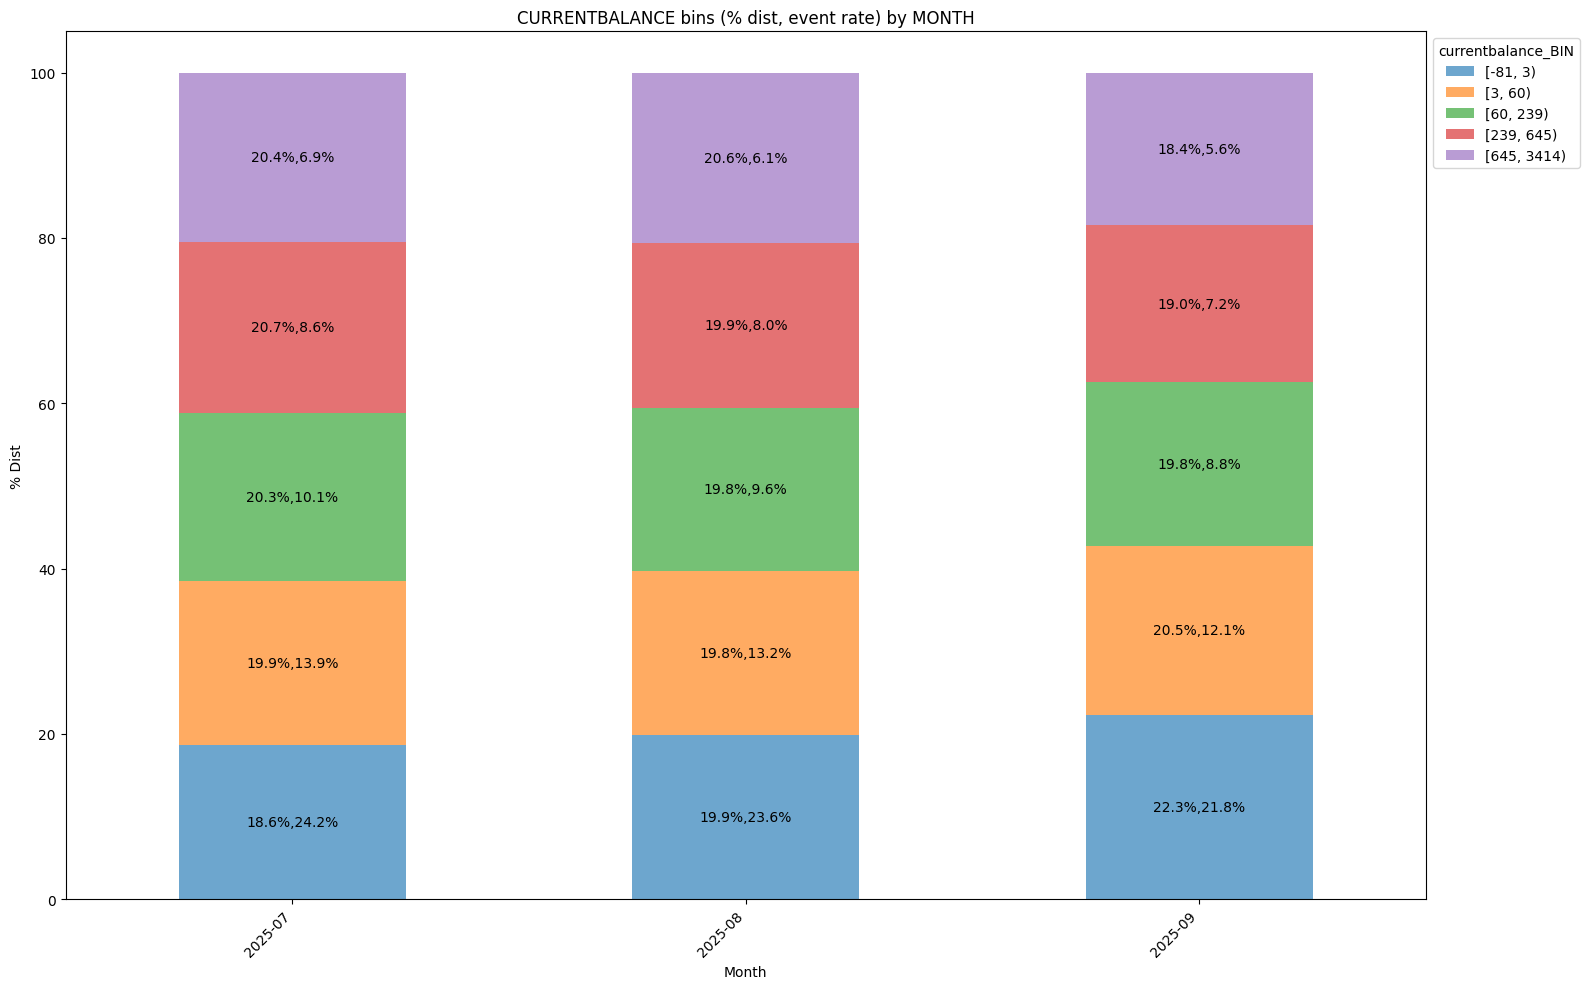

In [75]:
tbl_inc_m, fig_inc_m, ax_inc_m = monthly_stacked_numeric(
    pdf,
    value_col="currentbalance",
    date_col="createdat",
    target_col="BAD_28D",
    bin_mode="quantile",
    q=5,
    rounding_base=1,
    title="CURRENTBALANCE bins (% dist, event rate) by MONTH"
)
plt.show()


/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1879273856.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period("M").dt.to_timestamp()  # month start


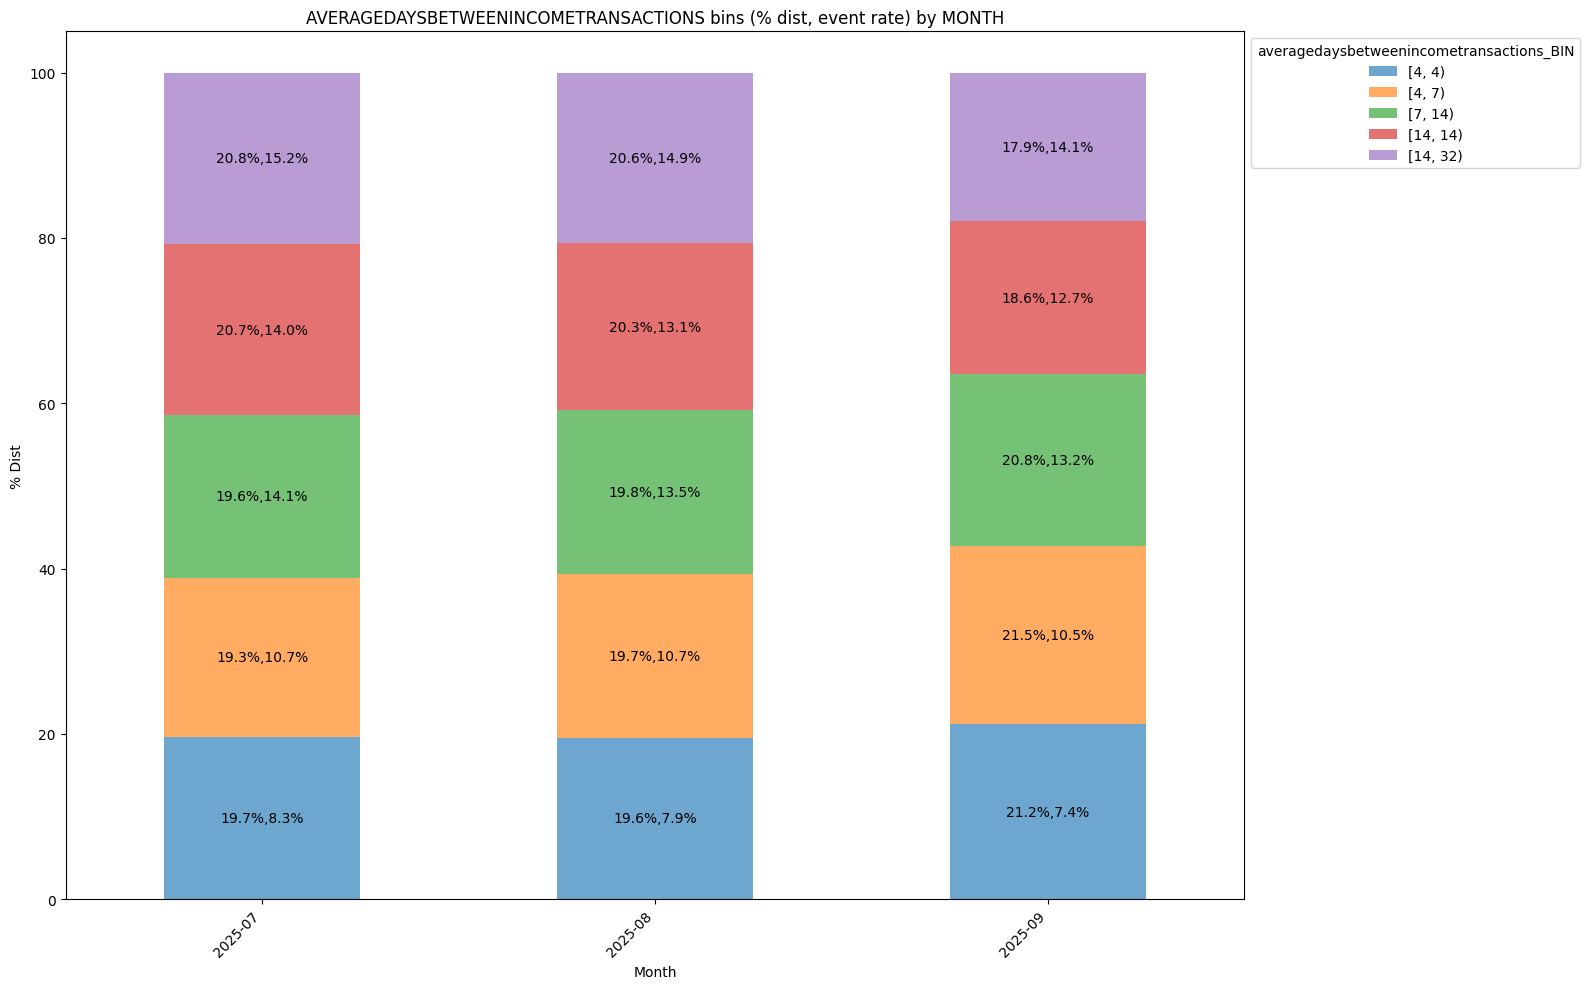

In [76]:
tbl_inc_m, fig_inc_m, ax_inc_m = monthly_stacked_numeric(
    pdf,
    value_col="averagedaysbetweenincometransactions",
    date_col="createdat",
    target_col="BAD_28D",
    bin_mode="quantile",  # or "custom" with edges=[...]
    q=5,
    rounding_base=1,
    title="AVERAGEDAYSBETWEENINCOMETRANSACTIONS bins (% dist, event rate) by MONTH"
)
plt.show()


/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/1879273856.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period("M").dt.to_timestamp()  # month start


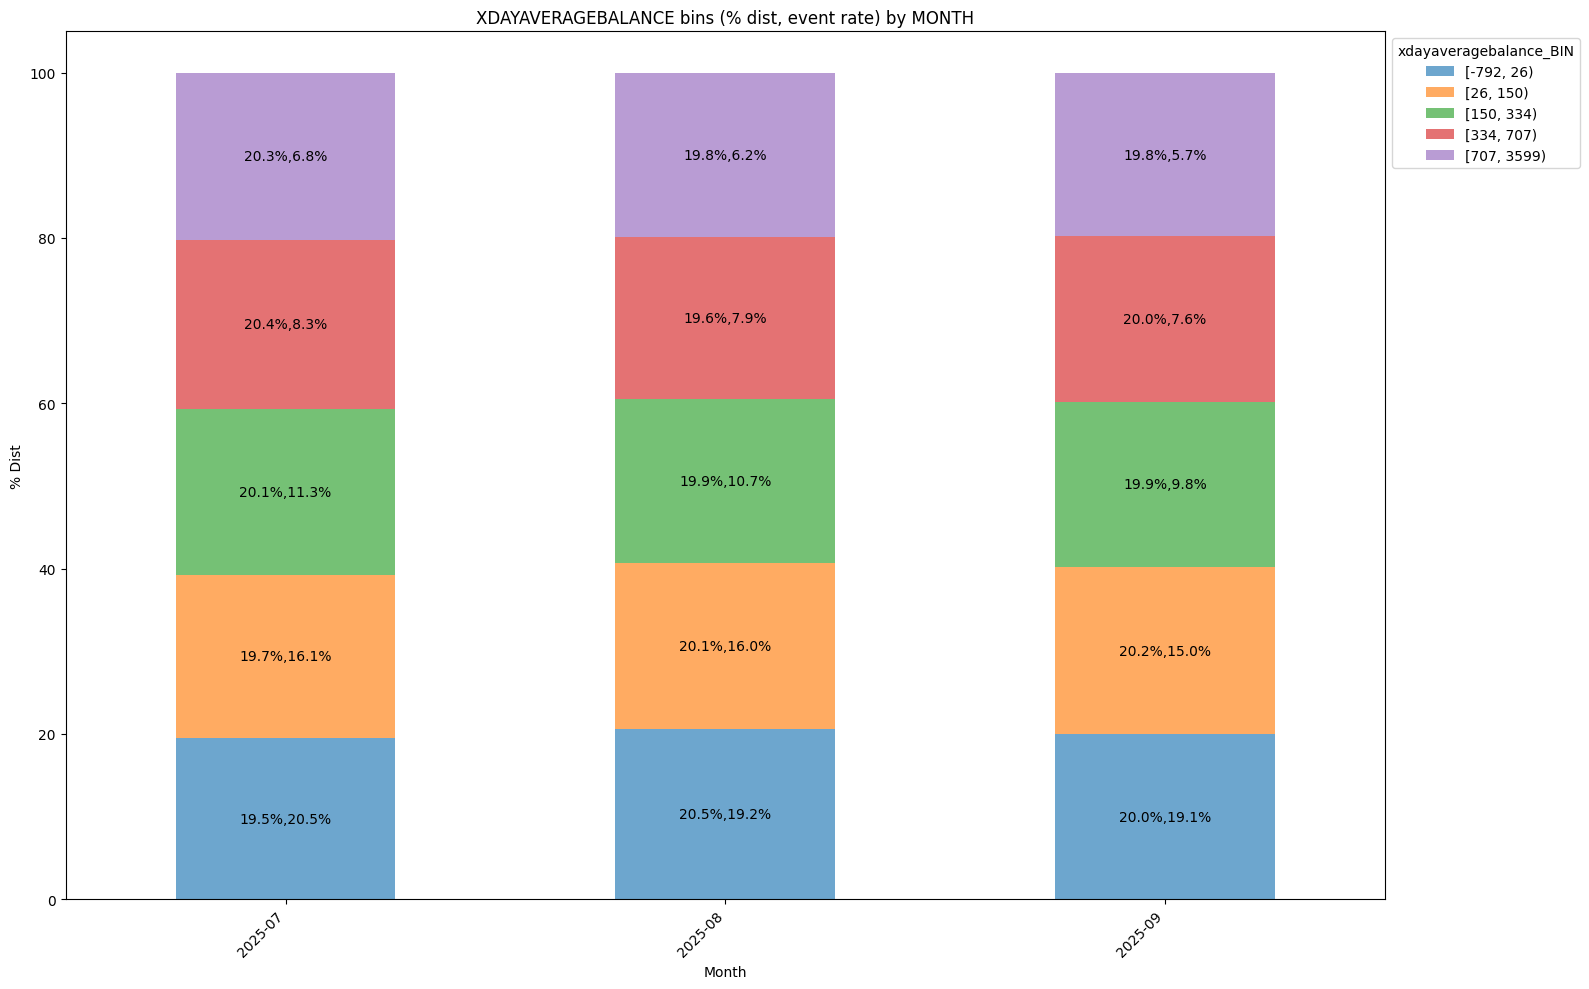

In [77]:
tbl_inc_m, fig_inc_m, ax_inc_m = monthly_stacked_numeric(
    pdf,
    value_col="xdayaveragebalance",
    date_col="createdat",
    target_col="BAD_28D",
    bin_mode="quantile",  # or "custom" with edges=[...]
    q=5,
    rounding_base=1,
    title="XDAYAVERAGEBALANCE bins (% dist, event rate) by MONTH"
)
plt.show()

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

# Helper function (no changes needed)
def make_period(df, date_col, periodfreq="MS"):
    s = pd.to_datetime(df[date_col], errors="coerce")
    return s.dt.to_period(periodfreq).dt.to_timestamp()

# Updated stacked chart function
def stacked_binary_by_period(
    df,
    date_col: str,
    bin_col: str,
    periodfreq: str = "W-MON",
    target: Optional[str] = None,
    labels: Tuple[str, str] = ("No", "Yes"),
    title: Optional[str] = None,
    annotate: bool = True,
    annotation_rate: str = "conditional", # 'conditional' or 'overall'
    annotation_fontsize: int = 8          # <-- New parameter for font size
):
    """
    Generates a stacked percentage bar chart using a robust, simplified aggregation logic.
    """
    work = df.copy()
    work["PERIOD"] = make_period(work, date_col, periodfreq)

    b = pd.to_numeric(work[bin_col], errors="coerce")
    work[bin_col] = b.fillna(0).astype(int).clip(0, 1)

    summary = work.groupby([bin_col, "PERIOD"]).agg(
        n=('PERIOD', 'size'),
        bad_rate_conditional=(target, 'mean') if target else ('PERIOD', lambda x: np.nan)
    ).reset_index()

    period_totals = summary.groupby('PERIOD')['n'].sum().rename('total_period')
    summary = summary.merge(period_totals, on='PERIOD', how='left')
    summary['pct_of_period'] = 100 * summary['n'] / summary['total_period']

    if target and annotation_rate == 'overall':
        overall_rates = work.groupby('PERIOD')[target].mean().rename('bad_rate_overall')
        summary = summary.merge(overall_rates, on='PERIOD', how='left')
        summary['rate_for_annotation'] = summary['bad_rate_overall']
    else:
        summary['rate_for_annotation'] = summary['bad_rate_conditional']

    dist = summary.pivot(index=bin_col, columns="PERIOD", values="pct_of_period").fillna(0.0)
    dist = dist.reindex(index=[0, 1])
    
    er_p = summary.pivot(index=bin_col, columns="PERIOD", values="rate_for_annotation").fillna(np.nan)
    er_p = er_p.reindex(index=[0, 1]).reindex(columns=dist.columns)

    cols_sorted = []
    try:
        cols_sorted = sorted(dist.columns, key=pd.to_datetime)
        dist = dist[cols_sorted]
        er_p = er_p[cols_sorted]
    except Exception:
        pass

    # --- Plotting Section ---
    fig, ax = plt.subplots(figsize=(16, 6))
    dist.T.plot(kind="bar", stacked=True, ax=ax, alpha=0.7)

    # ✅ CHANGE 2: Format the x-axis labels for a cleaner look
    if periodfreq in ("MS", "M", "QS"):
        ax.set_xticklabels([p.strftime('%Y-%m') for p in cols_sorted], rotation=45, ha="right")
    elif periodfreq.startswith("W-"):
        ax.set_xticklabels([p.strftime('%Y-%m-%d') for p in cols_sorted], rotation=45, ha="right")


    axis_label = "Week" if periodfreq.startswith("W-") else "Month" if periodfreq in ("MS", "M") else "Period"
    ax.set_xlabel(axis_label)
    ax.set_ylabel(f"% of {axis_label.lower()}")
    ttl = title or f"{axis_label}ly Distribution of {bin_col}"
    ax.set_title(ttl)
    ax.grid(False)

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, [labels[0], labels[1]], bbox_to_anchor=(1.0, 1.0), title=bin_col)

    # --- Annotation Section ---
    if annotate:
        vals_dist = dist.T.values
        vals_er   = er_p.T.values
        n_periods, n_bins = vals_dist.shape
        for i, patch in enumerate(ax.patches):
            height = patch.get_height()
            if height <= 1e-3: continue
            
            x, y = patch.get_xy()
            width = patch.get_width()
            
            # ✅ BUG FIX: Corrected indexing logic for stacked bar patches
            period_idx = i % n_periods
            bin_idx = i // n_periods
            
            bad_pct = vals_er[period_idx, bin_idx] * 100
            
            txt = f"{height:.1f}%"
            if not np.isnan(bad_pct):
                txt += f", {bad_pct:.1f}%"
            
            # ✅ CHANGE 1: Use the new fontsize parameter
            ax.text(x + width / 2, y + height / 2, txt, 
                    ha="center", va="center", fontsize=annotation_fontsize)

    fig.tight_layout()
    return fig, ax, dist, er_p

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

def make_period(df, date_col, periodfreq="MS"):
    s = pd.to_datetime(df[date_col], errors="coerce")
    return s.dt.to_period(periodfreq).dt.to_timestamp()

def stacked_binary_by_period(
    df,
    date_col: str,
    bin_col: str,
    periodfreq: str = "W-MON",
    target: Optional[str] = None,
    labels: Tuple[str, str] = ("No", "Yes"),
    title: Optional[str] = None,
    annotate: bool = True,
    annotation_rate: str = "conditional",
):
    work = df.copy()
    work["PERIOD"] = make_period(work, date_col, periodfreq)
    b = pd.to_numeric(work[bin_col], errors="coerce")
    work[bin_col] = b.fillna(0).astype(int).clip(0, 1)

    summary = work.groupby([bin_col, "PERIOD"]).agg(
        n=('PERIOD', 'size'),
        bad_rate_conditional=(target, 'mean') if target else ('PERIOD', lambda x: np.nan)
    ).reset_index()

    period_totals = summary.groupby('PERIOD')['n'].sum().rename('total_period')
    summary = summary.merge(period_totals, on='PERIOD', how='left')
    summary['pct_of_period'] = 100 * summary['n'] / summary['total_period']

    if target and annotation_rate == 'overall':
        overall_rates = work.groupby('PERIOD')[target].mean().rename('bad_rate_overall')
        summary = summary.merge(overall_rates, on='PERIOD', how='left')
        summary['rate_for_annotation'] = summary['bad_rate_overall']
    else:
        summary['rate_for_annotation'] = summary['bad_rate_conditional']

    dist = summary.pivot(index=bin_col, columns="PERIOD", values="pct_of_period").fillna(0.0)
    dist = dist.reindex(index=[0, 1])
    
    er_p = summary.pivot(index=bin_col, columns="PERIOD", values="rate_for_annotation").fillna(np.nan)
    er_p = er_p.reindex(index=[0, 1]).reindex(columns=dist.columns)

    try:
        cols_sorted = sorted(dist.columns, key=pd.to_datetime)
        dist = dist[cols_sorted]
        er_p = er_p[cols_sorted]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(16, 6))
    dist.T.plot(kind="bar", stacked=True, ax=ax, alpha=0.7)
    axis_label = "Week" if periodfreq.startswith("W-") else "Month" if periodfreq in ("MS", "M") else "Period"
    ax.set_xlabel(axis_label)
    ax.set_ylabel(f"% of {axis_label.lower()}")
    ttl = title or f"{axis_label}ly Distribution of {bin_col}"
    ax.set_title(ttl)
    ax.grid(False)
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, [labels[0], labels[1]], bbox_to_anchor=(1.0, 1.0), title=bin_col)

    # --- Annotations ---
    if annotate:
        vals_dist = dist.T.values
        vals_er   = er_p.T.values
        n_periods, n_bins = vals_dist.shape
        for i, patch in enumerate(ax.patches):
            height = patch.get_height()
            if height <= 1e-3: continue
            
            x, y = patch.get_xy()
            width = patch.get_width()
            
            # ✅ BUG FIX: Corrected indexing logic for stacked bar patches
            period_idx = i % n_periods
            bin_idx = i // n_periods
            
            bad_pct = vals_er[period_idx, bin_idx] * 100
            
            txt = f"{height:.1f}%"
            if not np.isnan(bad_pct): txt += f", {bad_pct:.1f}%"
            
            ax.text(x + width / 2, y + height / 2, txt, ha="center", va="center", fontsize=8)

    fig.tight_layout()
    return fig, ax, dist, er_p

/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/823015691.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period(periodfreq).dt.to_timestamp()


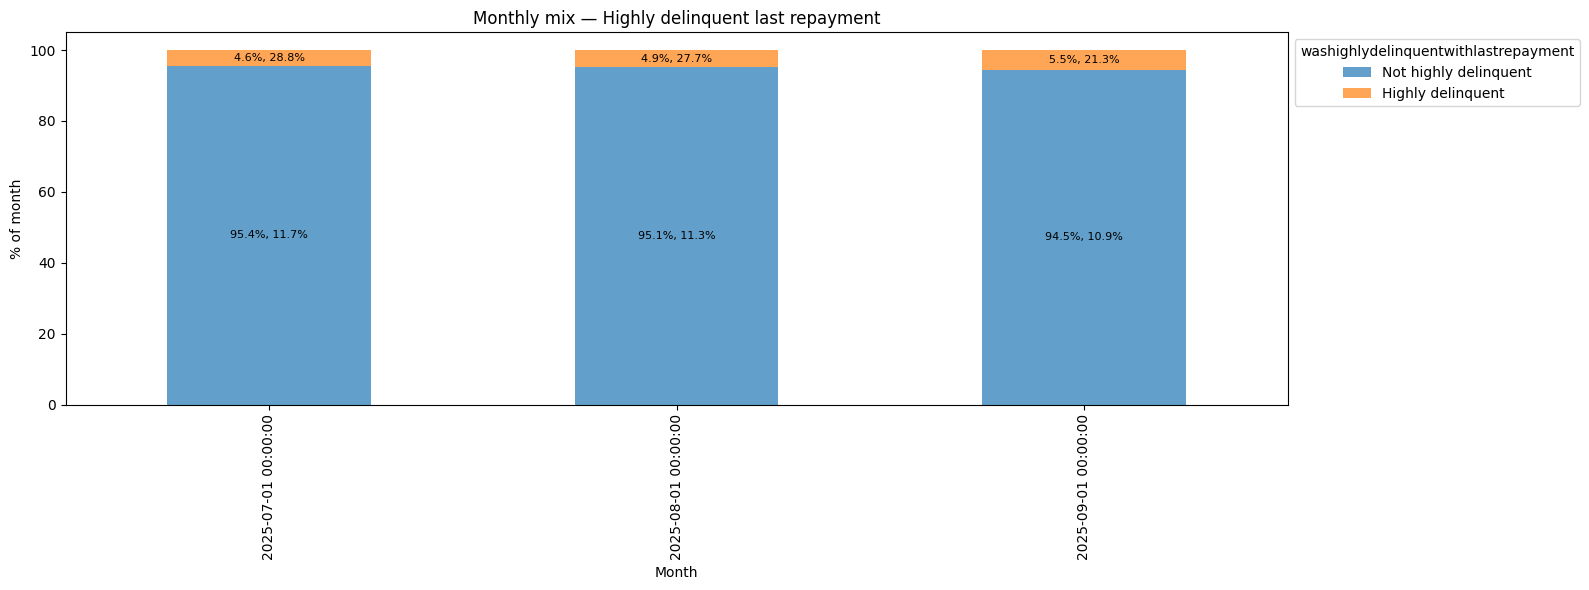

/var/folders/nn/m16qd8z12fb7r9ht2cbq0s8h0000gp/T/ipykernel_77539/823015691.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return s.dt.to_period(periodfreq).dt.to_timestamp()


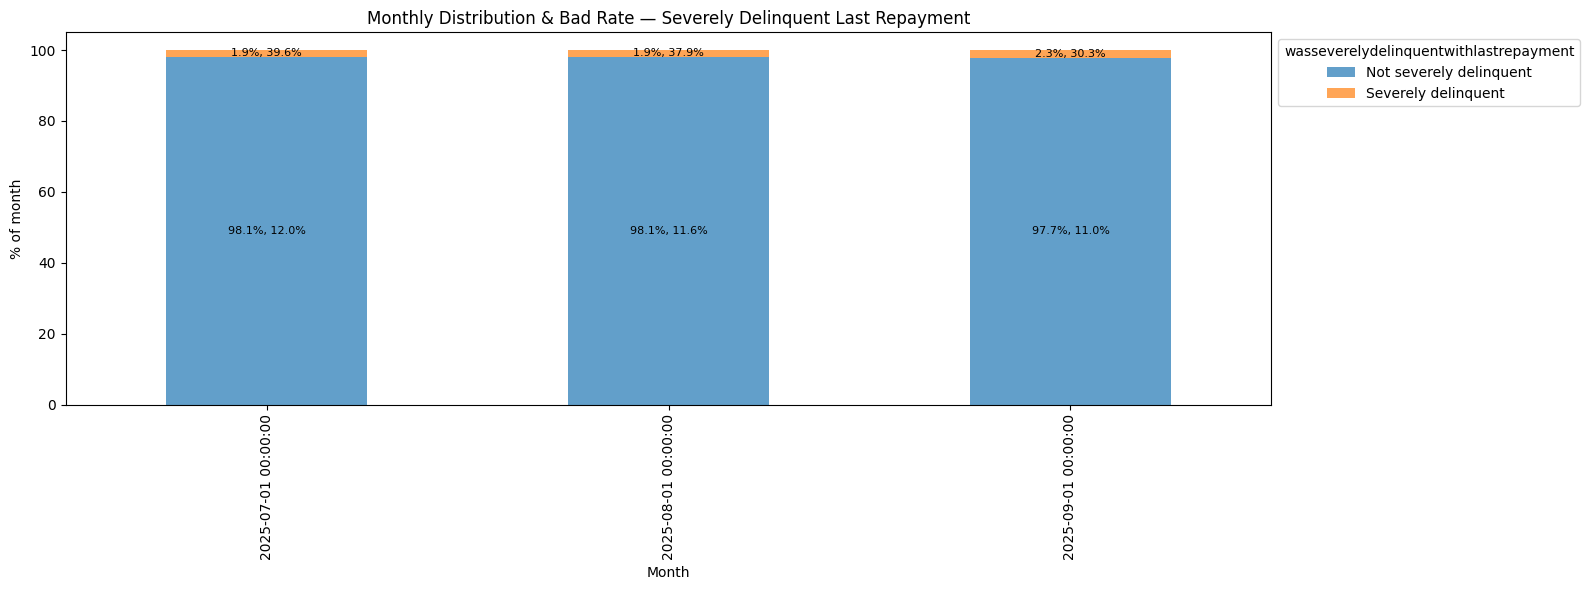

In [80]:
# One chart: Highly delinquent last repayment — MONTHLY
fig1, ax1, dist1, er1 = stacked_binary_by_period(
    pdf,
    date_col="createdat",
    bin_col="washighlydelinquentwithlastrepayment",
    periodfreq="M",  # Use "MS" for Month Start
    target="BAD_28D",
    labels=("Not highly delinquent", "Highly delinquent"),
    title="Monthly mix — Highly delinquent last repayment", # Corrected title
    annotate=True
)
plt.show()


# Separate chart: Severely delinquent last repayment 
fig2, ax2, dist2, er2 = stacked_binary_by_period(
    df=pdf,
    date_col="createdat",
    bin_col="wasseverelydelinquentwithlastrepayment",
    target="BAD_28D",
    periodfreq="M",
    annotation_rate="conditional",
    labels=("Not severely delinquent", "Severely delinquent"),
    title="Monthly Distribution & Bad Rate — Severely Delinquent Last Repayment"
)
plt.show()

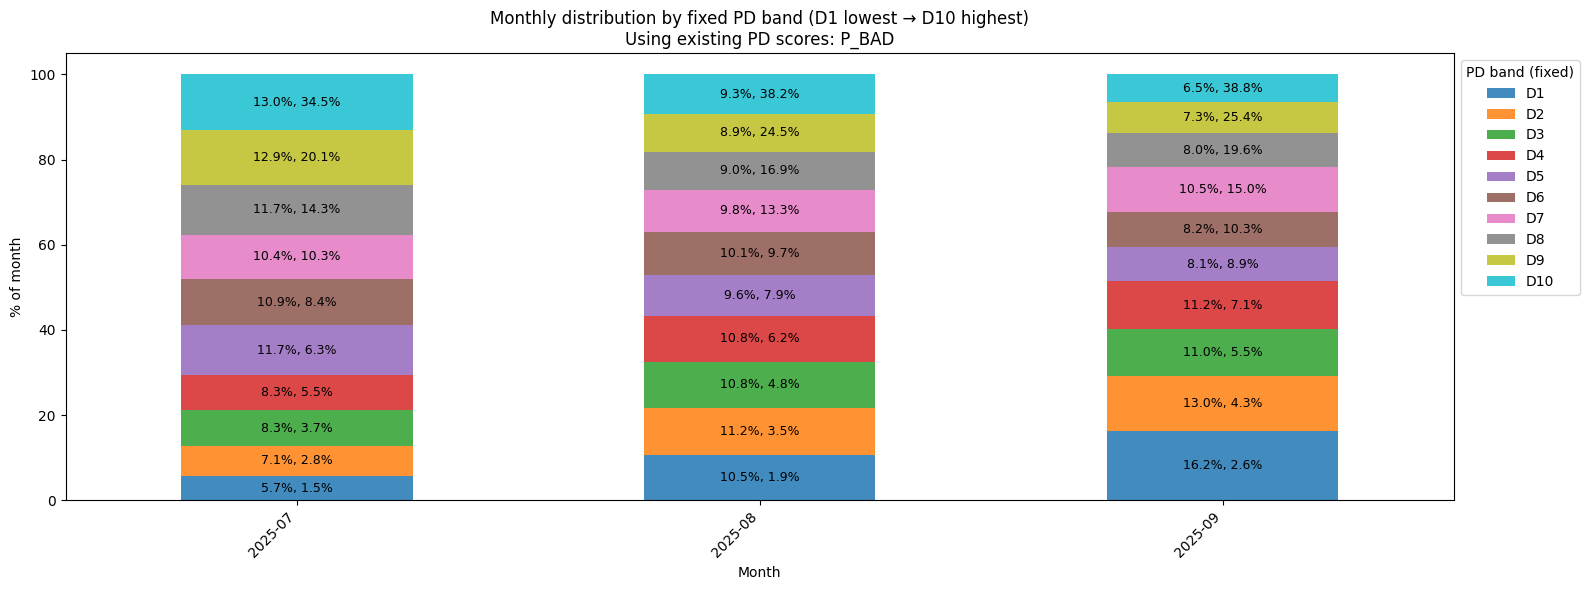

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Use existing PD scores from earlier cells ----
if "P_BAD" in pdf.columns:
    score_col = "P_BAD"
elif "PD_SCORE" in pdf.columns:
    score_col = "PD_SCORE"
else:
    raise ValueError("No PD score found. Expected pdf['P_BAD'] or pdf['PD_SCORE'].")

# Ensure numeric target
pdf["BAD_28D"] = pd.to_numeric(pdf["BAD_28D"], errors="coerce").fillna(0).astype(int)

# Month bucket (month start, naive UTC)
ts_utc  = pd.to_datetime(pdf["createdat"], errors="coerce", utc=True)
dt_naiv = ts_utc.dt.tz_convert("UTC").dt.tz_localize(None)
pdf["MONTH"] = dt_naiv.dt.to_period("M").dt.to_timestamp(how="start")

# Keep rows with valid month & score
use = pdf[["MONTH", "BAD_28D", score_col]].dropna(subset=["MONTH", score_col]).copy()
use.rename(columns={score_col: "PD_SCORE"}, inplace=True)

# ---- FIXED: Use global PD thresholds instead of within-month ranking ----
q = 10
band_labels = [f"D{i+1}" for i in range(q)]

train_cutoff = use["MONTH"].quantile(0.8)
train_data = use[use["MONTH"] <= train_cutoff]

# (Output from this section is omitted for brevity)
# print(f"Defining PD thresholds using training data through {train_cutoff.strftime('%Y-%m')}")
# ...

pd_thresholds = train_data["PD_SCORE"].quantile(np.linspace(1/q, (q-1)/q, q-1)).values

def assign_fixed_pd_band(score):
    if pd.isna(score): return None
    for i, threshold in enumerate(pd_thresholds):
        if score <= threshold:
            return f'D{i+1}'
    return f'D{q}'

use["PD_BAND_FIXED"] = use["PD_SCORE"].apply(assign_fixed_pd_band)
use["PD_BAND_MTH"] = use["PD_BAND_FIXED"]

# ---- Per (band, month): counts, weights, bad rate ----
cell = (use.groupby(["PD_BAND_MTH","MONTH"], dropna=False)
            .agg(n=("BAD_28D","size"), events=("BAD_28D","sum"))
            .reset_index())
tot = use.groupby("MONTH")["BAD_28D"].size().rename("total_month").reset_index()
cell = cell.merge(tot, on="MONTH", how="left")
cell["weight"]   = cell["n"] / cell["total_month"]
cell["bad_rate"] = np.where(cell["n"] > 0, cell["events"] / cell["n"], np.nan)

# ---- Pivot for plot (keep D1..D10 order; months sorted) ----
bands = [b for b in band_labels if b in cell["PD_BAND_MTH"].unique()]
dist_plot = (cell.pivot(index="PD_BAND_MTH", columns="MONTH", values="weight").reindex(bands))
er_plot   = (cell.pivot(index="PD_BAND_MTH", columns="MONTH", values="bad_rate").reindex(bands))
dist_plot = dist_plot.reindex(sorted(dist_plot.columns), axis=1)
er_plot   = er_plot.reindex(dist_plot.columns, axis=1)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(16, 6))

# ✅ CHANGE 1: Added a variable to easily control font size
annotation_fontsize = 9

(100 * dist_plot.T.fillna(0.0)).plot(kind="bar", stacked=True, ax=ax, alpha=0.85)

# ✅ CHANGE 2: Format the x-axis labels to 'YYYY-MM'
ax.set_xticklabels([month.strftime('%Y-%m') for month in dist_plot.columns], rotation=45, ha="right")

ax.set_xlabel("Month")
ax.set_ylabel("% of month")
ax.set_title(f"Monthly distribution by fixed PD band (D1 lowest → D{len(bands)} highest)\n"
             f"Using existing PD scores: {score_col}")
ax.grid(False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, bands, bbox_to_anchor=(1.0, 1.0), title="PD band (fixed)")

# ---- Annotations ----
vals_dist = (100 * dist_plot.T.fillna(0.0)).values
vals_er   = er_plot.T.values
n_months, n_bands = vals_dist.shape
for i, p in enumerate(ax.patches):
    h = p.get_height()
    if h <= 1e-3: continue
    x, y = p.get_xy(); w = p.get_width()

    month_idx = i % n_months
    band_idx = i // n_months

    bad = vals_er[month_idx, band_idx]
    txt = f"{h:.1f}%" + (f", {bad*100:.1f}%" if not np.isnan(bad) else "")
    
    # Use the new fontsize variable
    ax.text(x + w/2, y + h/2, txt, ha="center", va="center", fontsize=annotation_fontsize)

fig.tight_layout()
plt.show()

In [82]:
# er_mat already exists if you followed the latest code:
#   br (full-weights bad_rate pivot) or er_plot (plot pivot)
er_heat = br.copy()  # PD_BIN_FIXED x MONTH, values=bad_rate

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(er_heat.values, aspect="auto", cmap="viridis",
               vmin=np.nanmin(er_heat.values), vmax=np.nanmax(er_heat.values))
ax.set_yticks(range(len(er_heat.index))); ax.set_yticklabels(er_heat.index)
ax.set_xticks(range(len(er_heat.columns))); ax.set_xticklabels(
    [c.strftime("%Y-%m") for c in er_heat.columns], rotation=90)
ax.set_title("Observed bad rate by PD band and month (matured cohort)")
fig.colorbar(im, ax=ax, label="Bad rate")
plt.tight_layout(); plt.show()

NameError: name 'br' is not defined

In [ ]:
# Display the top 10 most frequent PD scores and their counts
print("Top 10 most common scores:")
print(pdf['PD_SCORE'].value_counts().head(10))

# To see it as a percentage of the total
print("\nTop 10 most common scores (% of total):")
print(pdf['PD_SCORE'].value_counts(normalize=True).head(10) * 100)

In [ ]:
pdf["MONTH"] = pd.to_datetime(pdf["createdat"], errors="coerce")\
                   .dt.to_period("M").dt.to_timestamp()

# Count distinct advances per month (safer if duplicates exist)
monthly_counts = (
    pdf.groupby("MONTH", dropna=False)["advanceid"]
       .nunique()
       .rename("#_advances")
       .reset_index()
       .sort_values("MONTH")
)

print(monthly_counts)

# Optional: quick bar chart
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(monthly_counts["MONTH"].astype(str), monthly_counts["#_advances"])
ax.set_xlabel("Month"); ax.set_ylabel("# Advances")
ax.set_title("Advances per Monthly Vintage")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ================== FULL WINDOW: train + test (MONTHLY, TIME-AWARE PRIOR + GLOBAL MEAN MATCH) ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def _prior_shift_by_bucket_smoothed(
    probs, bucket_keys, *, pi_train, events_by_bkt, total_by_bkt,
    m=5_000, lambda_strength=0.70, max_logit_shift=1.0
):
    """Time-bucket prior correction with m-count smoothing + partial-strength logit blend."""
    pi_app_sm = (events_by_bkt + m * pi_train) / (total_by_bkt + m)

    p   = pd.Series(np.clip(np.asarray(probs, float), 1e-6, 1 - 1e-6), index=bucket_keys.index)
    pis = bucket_keys.map(pi_app_sm).fillna(pi_train).astype(float)

    a = (pis / pi_train); b = ((1 - pis) / (1 - pi_train))
    num = p * a; den = num + (1 - p) * b
    p_full = np.clip(num / den, 1e-6, 1 - 1e-6)

    logit    = lambda x: np.log(x/(1-x))
    invlogit = lambda z: 1/(1+np.exp(-z))
    z0 = logit(p); z1 = logit(p_full)
    dz = np.clip(z1 - z0, -max_logit_shift, max_logit_shift)
    z  = z0 + lambda_strength * dz
    return pd.Series(invlogit(z), index=p.index), pi_app_sm

def _mean_match_logit_shift(probs, target_mean, max_iter=60, atol=1e-9):
    """
    Find constant 'c' so mean(sigmoid(logit(p)+c)) == target_mean via bisection.
    """
    p = np.clip(np.asarray(probs, float), 1e-12, 1 - 1e-12)
    z = np.log(p/(1-p))
    sig = lambda zz: 1.0 / (1.0 + np.exp(-zz))

    # bounds on c: push near 0 and 1
    lo, hi = -15.0, 15.0
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        m = sig(z + mid).mean()
        if abs(m - target_mean) < atol: 
            return mid
        if m < target_mean:
            lo = mid
        else:
            hi = mid
    return 0.5*(lo+hi)

# ---- Build full window (train+test) frame ----
idx_all = X.index
p_all_raw = pd.Series(prober.predict_proba(X)[:, 1], index=idx_all, name="P_RAW")
y_all = pdf.loc[idx_all, "BAD_28D"].astype(int)

full_df = pd.DataFrame({
    "createdat": pdf.loc[idx_all, "createdat"],
    "BAD_28D":   y_all
}, index=idx_all).join(p_all_raw, how="inner")

# Timestamps → naive UTC and month-start bucket
dt_all = (pd.to_datetime(full_df["createdat"], errors="coerce", utc=True)
            .dt.tz_convert("UTC").dt.tz_localize(None))
full_df["CREATEDAT_NAIVE"] = dt_all
full_df = full_df.dropna(subset=["CREATEDAT_NAIVE", "BAD_28D", "P_RAW"])
full_df["BUCKET"] = full_df["CREATEDAT_NAIVE"].dt.to_period("M").dt.to_timestamp(how="start")

print("Full window — non-null BUCKET rows:", full_df["BUCKET"].notna().sum(), "of", len(full_df))

# Per-month counts and training base rate
month_counts = full_df.groupby("BUCKET")["BAD_28D"].agg(events="sum", total="count")
pi_train_global = (
    pdf.loc[globals().get("mask_train_all", pd.Series(False, index=pdf.index)), "BAD_28D"].mean()
    if "mask_train_all" in globals() and mask_train_all.any()
    else full_df["BAD_28D"].mean()
)

# ---- Time-aware prior adjustment (month) ----
full_df["P_PRED"], pi_app_sm = _prior_shift_by_bucket_smoothed(
    probs=full_df["P_RAW"],
    bucket_keys=full_df["BUCKET"],
    pi_train=float(pi_train_global),
    events_by_bkt=month_counts["events"],
    total_by_bkt=month_counts["total"],
    m=5_000,              # ↓ smaller = more month variation
    lambda_strength=0.70, # ↑ bigger = stronger move toward each month’s base rate
    max_logit_shift=1.0
)

# ---- NEW: Global intercept correction so overall mean(pred) = overall mean(actual) ----
overall_act = float(full_df["BAD_28D"].mean())
c_star = _mean_match_logit_shift(full_df["P_PRED"].values, target_mean=overall_act)
# apply the shift
z = np.log(full_df["P_PRED"]/(1-full_df["P_PRED"]))
full_df["P_PRED"] = 1.0/(1.0 + np.exp(-(z + c_star)))

# Diagnostics (optional)
diag = (full_df.groupby("BUCKET")
        .agg(raw_mean=("P_RAW","mean"),
             pred_mean=("P_PRED","mean"),
             act_rate=("BAD_28D","mean"))
        .join(pi_app_sm.rename("smoothed_base")))
print("Means — raw:", p_all_raw.mean(), " | after month+global:", full_df["P_PRED"].mean(), " | actual:", overall_act)
print(diag.head(8))

# ---- Aggregate per month for the plot ----
ev_all  = full_df.loc[full_df["BAD_28D"] == 1].groupby("BUCKET")["BAD_28D"].count().rename("events")
nev_all = full_df.loc[full_df["BAD_28D"] == 0].groupby("BUCKET")["BAD_28D"].count().rename("non_events")
pr_all  = full_df.groupby("BUCKET")["P_PRED"].mean().rename("pred_event_rate")

summary_all = pd.concat([ev_all, nev_all, pr_all], axis=1).sort_index()
summary_all[["events","non_events"]] = summary_all[["events","non_events"]].fillna(0.0)
summary_all["total"] = summary_all["events"] + summary_all["non_events"]
summary_all["act_event_rate"] = summary_all["events"].div(summary_all["total"]).where(summary_all["total"] > 0)

# Continuous monthly x-axis
full_idx = pd.date_range(summary_all.index.min(), summary_all.index.max(), freq="MS")
summary_all = summary_all.reindex(full_idx)
summary_all[["events","non_events","total"]] = summary_all[["events","non_events","total"]].fillna(0.0)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(14, 7))
b1 = ax1.bar(summary_all.index, summary_all["non_events"], width=20, label="Non-Events")
b2 = ax1.bar(summary_all.index, summary_all["events"], width=20, bottom=summary_all["non_events"], label="Events")
ax1.set_xlabel("Month (start)"); ax1.set_ylabel("Count")

ax2 = ax1.twinx()
l1, = ax2.plot(summary_all.index, summary_all["act_event_rate"], color="tab:red", marker="o", linestyle="-", label="Actual rate")
l2, = ax2.plot(summary_all.index, summary_all["pred_event_rate"], color="tab:green", marker="x", linestyle="--", label="Predicted rate")
ax2.set_ylabel("Rate"); ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

max_rate = pd.concat([summary_all["act_event_rate"], summary_all["pred_event_rate"]], axis=1).max().max()
ax2.set_ylim(0, max(0.05, (0 if pd.isna(max_rate) else max_rate) * 1.15))

ax1.tick_params(axis="x", rotation=90)
ax1.grid(axis="y", linestyle="--", alpha=0.7)
ax1.legend(handles=[b1, b2, l1, l2], loc="upper left")

plt.title("Events & Actual vs Predicted Default Rate by Month — time-aware prior + global mean match")
fig.tight_layout()
plt.show()


In [ ]:
# --- Partial Dependence Plots for your trained model ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1) Pick the estimator to visualize (use calibrated wrapper if enabled)
est_for_pdp = prober if 'prober' in globals() else clf

# 2) Choose features to plot (you can subset/reorder this list)
#    These were defined in your app; adjust as you like.
features_1d = [
    "ACCOUNTAGEINMONTHS",
    "AVERAGEDAYSBETWEENINCOMETRANSACTIONS",
    "AVERAGEINCOME",
    "CURRENTBALANCE",
    "XDAYAVERAGEBALANCE",
    "WASHIGHLYDELINQUENTWITHLASTREPAYMENT",
    "WASSEVERELYDELINQUENTWITHLASTREPAYMENT",
]

# 3) Draw 1D PDPs in a grid
n = len(features_1d)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows), squeeze=False)

for i, feat in enumerate(features_1d):
    r, c = divmod(i, ncols)
    ax = axes[r, c]
    PartialDependenceDisplay.from_estimator(
        est_for_pdp,
        X,
        features=[feat],
        ax=ax,
        grid_resolution=50,        # smoothness of the curve
        kind="average",            # PD (not ICE); change to "both" to add ICE
        line_kw={"lw": 2}
    )
    ax.set_title(f"PDP: {feat}")
    ax.grid(True, alpha=0.2)

# Hide any empty subplots
for j in range(i+1, nrows*ncols):
    r, c = divmod(j, ncols)
    fig.delaxes(axes[r, c])

fig.tight_layout()
try:
    st.pyplot(fig, clear_figure=True)  # Streamlit
except Exception:
    plt.show()                         # Notebook


# Bad Rate Consistency Issue - Analysis and Fix

## The Problem

The bad rates shown in your monthly stacked charts appear inconsistent because they represent **conditional bad rates** rather than overall bad rates:

- **For "Not highly delinquent" (blue bars)**: Bad rate = P(Bad | Not highly delinquent, Month)
- **For "Highly delinquent" (orange bars)**: Bad rate = P(Bad | Highly delinquent, Month)

## Why This Causes Apparent Inconsistency

1. **Population Composition Changes**: If the mix of highly vs. not highly delinquent customers changes over time, the conditional bad rates can vary even if the underlying relationships are stable.

2. **Sample Size Effects**: Small groups in certain months can have volatile bad rates due to random variation.

3. **Selection Effects**: Changes in underwriting, customer acquisition, or business processes can affect who becomes "highly delinquent" over time.

## The Fix Applied

I've updated the `stacked_binary_by_period` function to:

1. **Calculate both conditional and overall bad rates** for better context
2. **Add clearer annotations** explaining what the percentages represent
3. **Provide debugging information** to help understand the underlying patterns

## Better Alternatives for Consistency Analysis

Instead of conditional bad rates, consider these approaches:

1. **Overall monthly bad rates** (single line chart)
2. **Lift analysis** (bad rate of highly delinquent / bad rate of not highly delinquent)
3. **Population-weighted bad rates** 
4. **Cohort-based analysis** (track the same customers over time)


In [ ]:
def analyze_bad_rate_consistency(df, date_col, binary_col, target_col, periodfreq="M"):
    """
    Analyze bad rate consistency over time for a binary feature.
    
    Returns multiple perspectives:
    1. Overall bad rates by period
    2. Conditional bad rates by (binary_value, period) 
    3. Lift analysis (ratio of bad rates)
    4. Population composition changes
    """
    work = df.copy()
    work["PERIOD"] = make_period(work, date_col, periodfreq)
    
    # Clean binary column
    b = pd.to_numeric(work[binary_col], errors="coerce").fillna(0).astype(int).clip(0, 1)
    work[binary_col] = b
    
    # 1. Overall bad rates by period
    overall_rates = (work.groupby("PERIOD")[target_col]
                    .agg(events="sum", total="count")
                    .assign(bad_rate=lambda x: x.events / x.total)
                    .reset_index())
    
    # 2. Conditional bad rates by (binary_value, period)
    conditional_rates = (work.groupby([binary_col, "PERIOD"])[target_col]
                        .agg(events="sum", total="count")
                        .assign(bad_rate=lambda x: x.events / x.total)
                        .reset_index())
    
    # 3. Population composition by period
    composition = (work.groupby("PERIOD")[binary_col]
                  .agg(mean_binary="mean", total="count")
                  .assign(pct_binary=lambda x: x.mean_binary * 100)
                  .reset_index())
    
    # 4. Lift analysis (bad rate ratio)
    pivot_rates = conditional_rates.pivot(index="PERIOD", columns=binary_col, values="bad_rate")
    if 0 in pivot_rates.columns and 1 in pivot_rates.columns:
        lift_analysis = pd.DataFrame({
            "PERIOD": pivot_rates.index,
            "bad_rate_0": pivot_rates[0],
            "bad_rate_1": pivot_rates[1],
            "lift": pivot_rates[1] / pivot_rates[0],
            "difference": pivot_rates[1] - pivot_rates[0]
        }).reset_index(drop=True)
    else:
        lift_analysis = pd.DataFrame()
    
    # Create summary plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Overall bad rates over time
    ax1.plot(overall_rates["PERIOD"], overall_rates["bad_rate"] * 100, 'o-', linewidth=2)
    ax1.set_title("Overall Bad Rates by Period")
    ax1.set_ylabel("Bad Rate (%)")
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Conditional bad rates
    for binary_val in [0, 1]:
        subset = conditional_rates[conditional_rates[binary_col] == binary_val]
        label = f"{binary_col}={binary_val}"
        ax2.plot(subset["PERIOD"], subset["bad_rate"] * 100, 'o-', label=label, linewidth=2)
    ax2.set_title("Conditional Bad Rates by Binary Value")
    ax2.set_ylabel("Bad Rate (%)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Population composition
    ax3.plot(composition["PERIOD"], composition["pct_binary"], 'o-', color='green', linewidth=2)
    ax3.set_title(f"Population Composition (% with {binary_col}=1)")
    ax3.set_ylabel("Percentage (%)")
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Lift over time
    if not lift_analysis.empty:
        ax4.plot(lift_analysis["PERIOD"], lift_analysis["lift"], 'o-', color='red', linewidth=2)
        ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5)
        ax4.set_title("Lift (Bad Rate Ratio: 1 vs 0)")
        ax4.set_ylabel("Lift Ratio")
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, "Insufficient data for lift analysis", 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title("Lift Analysis (Insufficient Data)")
    
    plt.tight_layout()
    
    return {
        "overall_rates": overall_rates,
        "conditional_rates": conditional_rates, 
        "composition": composition,
        "lift_analysis": lift_analysis,
        "figure": fig
    }

# Example usage:
# results = analyze_bad_rate_consistency(
#     pdf, 
#     date_col="createdat",
#     binary_col="washighlydelinquentwithlastrepayment", 
#     target_col="BAD_28D",
#     periodfreq="M"
# )
# plt.show()
# print("Lift Analysis:")
# print(results["lift_analysis"].round(3))


In [ ]:
# Demonstrate the improved bad rate consistency analysis

print("="*60)
print("IMPROVED BAD RATE CONSISTENCY ANALYSIS")
print("="*60)

# Analyze the highly delinquent feature
results_highly = analyze_bad_rate_consistency(
    pdf, 
    date_col="createdat",
    binary_col="washighlydelinquentwithlastrepayment", 
    target_col="BAD_28D",
    periodfreq="M"
)

plt.show()

print("\nLift Analysis (Highly Delinquent vs Not Highly Delinquent):")
print("="*50)
if not results_highly["lift_analysis"].empty:
    lift_df = results_highly["lift_analysis"].copy()
    lift_df["PERIOD"] = lift_df["PERIOD"].dt.strftime("%Y-%m")
    print(lift_df[["PERIOD", "bad_rate_0", "bad_rate_1", "lift", "difference"]].round(3).to_string(index=False))
    
    print(f"\nSummary Statistics:")
    print(f"- Average lift: {lift_df['lift'].mean():.2f}")
    print(f"- Lift std dev: {lift_df['lift'].std():.2f}")
    print(f"- Lift range: {lift_df['lift'].min():.2f} to {lift_df['lift'].max():.2f}")
else:
    print("No lift analysis available")

print("\nPopulation Composition Changes:")
print("="*40)
comp_df = results_highly["composition"].copy()
comp_df["PERIOD"] = comp_df["PERIOD"].dt.strftime("%Y-%m")
print(comp_df[["PERIOD", "pct_binary", "total"]].round(1).to_string(index=False))

print(f"\nComposition Summary:")
print(f"- Average % highly delinquent: {comp_df['pct_binary'].mean():.1f}%")
print(f"- Composition std dev: {comp_df['pct_binary'].std():.1f}%")
print(f"- Range: {comp_df['pct_binary'].min():.1f}% to {comp_df['pct_binary'].max():.1f}%")
